# linkedin-skill-forecasting-2025

**Author : Dinesh Kumaralingam**

Data Set : Data scraped from Linkedin - Job Postings


# Background and Motivation:
In recent years, the labor market for data and analytics‐oriented roles has grown rapidly across multiple industries—technology, finance, healthcare, and beyond. Employers increasingly demand a balanced mix of both core technical (“hard”) skills (e.g., Python, SQL, machine learning frameworks) and “soft” or interpersonal skills (e.g., communication, teamwork, problem‐solving). At the same time, geographic location and industry sector (e.g., fintech versus biotech) appear to influence which combinations of emerging versus legacy skills are most valued. Understanding these patterns can inform both job seekers (on how to upskill) and employers (on how to tailor training programs).

# Dataset Description:
For this study, I collected (or “scraped”) job‐posting data from LinkedIn, focusing exclusively on five target roles:

*   **Data Analyst**
*   **Data Scientist**
*   **Consultant**
*   **Supply Chain Analyst**
*   **Marketing Analyst**

Each record in the resulting dataset corresponds to a single LinkedIn job posting and includes, at minimum, the following fields:

**Job Title** (e.g., “Senior Data Analyst,” “Entry‐Level Consultant”)

**Company Name** (e.g., “Meta,” “FanDuel,” “Accenture”)

**Location** (city / state / country)

**Job Description Text** (free‐text listing responsibilities and requirements)

**Skills List** (a cleaned, comma‐separated array of


explicitly listed skills such as “Python,” “Communication,” “Tableau”)

Overall, the dataset file contains approximately 800,000 unique postings spanning North America, Europe, and beyond, all timestamped during calendar year 2024–2025. I have standardized location strings (e.g., “New York, NY,” “San Francisco, CA”) and applied basic text cleaning to convert the original “skills” strings into Python lists.

# Research Questions and Project Goals:
**This project seeks to answer three primary research questions:**


1.   Which core technical and soft skills co‐occur most frequently in 2025 job postings for each role?

• Using frequent‐pattern mining (FP‐Growth), I will identify the top 10 skill‐pair combinations for each of the five roles.
• By visualizing these co‐occurrence patterns in punchy horizontal bar charts, I aim to reveal which “hard + hard,” “hard + soft,” and “soft + soft” pairs dominate each role.

2.   How do soft‐skill versus hard‐skill mixes vary by role, and what does that imply for future training priorities?

• I will classify each skill as either “soft” (e.g., communication, leadership, teamwork) or “hard” (e.g., SQL, Python, Tableau) via a simple keyword‐matching heuristic.
• Using K-Means clustering on the vector
[hard_count,soft_count], I will assign each posting to one of three clusters:

*   Cluster 0 (Hard‐Heavy) – High hard‐skill count relative to soft‐skill count
*   Cluster 1 (Balanced) – Roughly equal numbers of hard and soft skills
*   Cluster 2 (Soft‐Heavy) – High soft‐skill count relative to hard‐skill count

• I will visualize these clusters on a scatter plot of
hard_count vs. soft_count, color‐coded by cluster, and compare cluster proportions across roles (e.g., Data Science vs. Consulting).

3.   How does the geography or industry (tech vs. finance vs. healthcare) of a posting shift the balance of emerging vs. legacy skills for these five roles?

• I will first isolate each role’s postings by matching job‐title keywords (e.g., “data analyst,” “consultant”) within a larger “linkedin_job_postings.csv” dataset that contains a broader set of roles—including metadata such as job‐location and industry tags (when available).
• Next, I will vectorize each job description’s free‐text (e.g., “We are looking for someone experienced with TensorFlow, Hadoop, and microservices…”) using TF-IDF, then apply K-Means clustering 𝐾Midwest for finance hubs.

# Exploratory Data Analysis:

Number of unique postings: 1296381
Unique skills total: 3301508
Avg skills per posting: 20.769542287336826


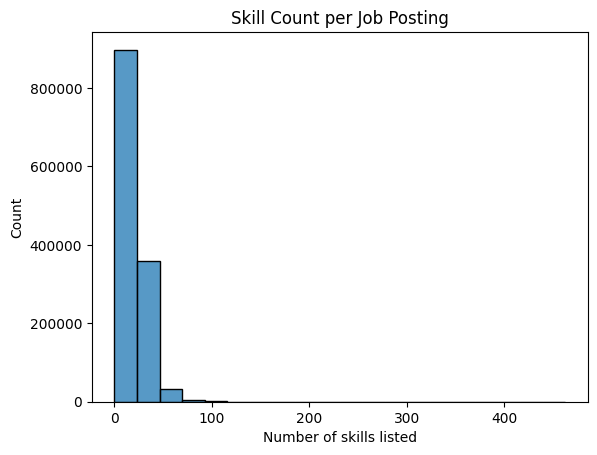

           Data Analyst      Data Scientist              Consultant  \
#1                  SQL              Python           Communication   
#2        Data Analysis                 SQL                   Sales   
#3               Python        Data Science        Customer service   
#4              Tableau    Machine Learning                Teamwork   
#5   Data Visualization                   R        Customer Service   
#6                    R          Statistics    Communication skills   
#7        Communication  Data Visualization         Problem Solving   
#8             Power BI       Communication              Leadership   
#9        Data analysis             Tableau             Negotiation   
#10               Excel               Spark  Microsoft Office Suite   

      Marketing Analyst  
#1                  SQL  
#2        Data Analysis  
#3              Tableau  
#4        Communication  
#5                Excel  
#6        Data analysis  
#7   Data Visualization  
#8     Goo

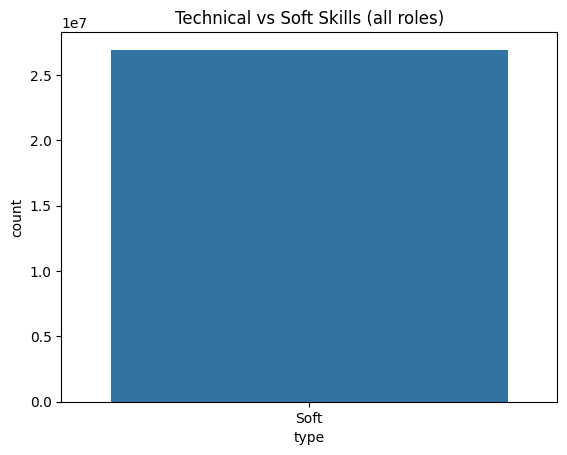

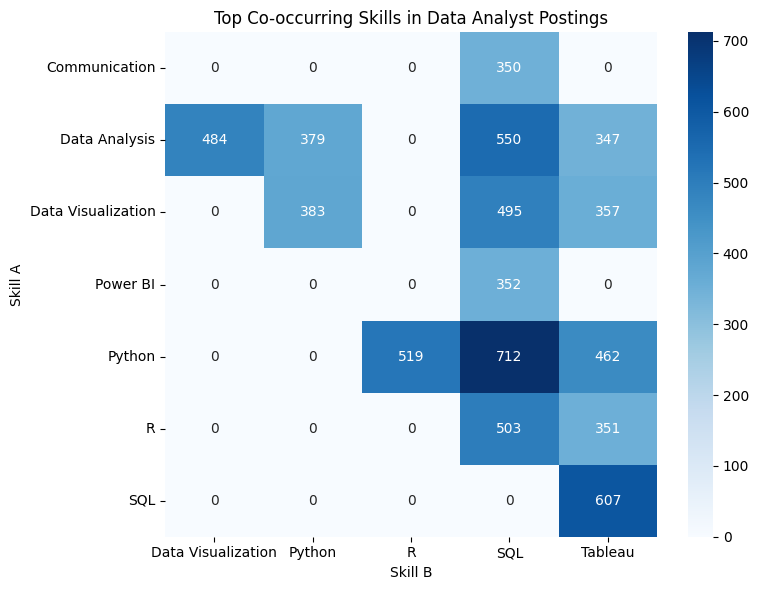

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import combinations

# ——— 1) Load data —————————————————————————————————————
# A) Wide: one row per title, skills as list
wide = pd.read_csv("titles_and_skills_clean.csv",
                   converters={"job_skills": eval})

# B) Long: one row per (title, skill)
long = pd.read_csv("title_skill_pairs.csv")

# Filter only the four roles (case‐insensitive)
roles = ["Data Analyst","Data Scientist","Consultant","Marketing Analyst"]
mask = long["job_title"].str.lower().apply(
    lambda t: any(r.lower() in t for r in roles)
)
df = long[mask].copy()


# ——— 2) Basic summaries ——————————————————————————————
print("Number of unique postings:", wide.shape[0])
print("Unique skills total:", long["skill"].nunique())
print("Avg skills per posting:", wide["job_skills"].apply(len).mean())


# Visualize skills‐per‐posting distribution
sns.histplot(wide["job_skills"].apply(len), bins=20)
plt.xlabel("Number of skills listed")
plt.title("Skill Count per Job Posting")
plt.show()


# ——— 3) Top N skills per role ——————————————————————————
top_by_role = {}
for role in roles:
    sub = df[df.job_title.str.contains(role, case=False)]
    cnt = Counter(sub["skill"])
    top_by_role[role] = cnt.most_common(10)

# Turn into a DataFrame for presentation
top_df = pd.DataFrame({
    role: [s for s,_ in top_by_role[role]]
    for role in roles
}, index=[f"#{i+1}" for i in range(10)])
print(top_df)


# ——— 4) Tech vs. soft skill breakdown ——————————————————————
# (Assuming you manually tag each skill in wide or create two lists)
technical = {...}  # e.g. {"SQL","Python",...}
long["type"] = long["skill"].apply(lambda s: "Tech" if s in technical else "Soft")
sns.countplot(data=long, x="type")
plt.title("Technical vs Soft Skills (all roles)")
plt.show()


# ——— 5) Skill co-occurrence heatmap —————————————————————
da_skills = wide[wide.job_title.str.contains("Data Analyst", case=False)]["job_skills"]
pair_counts = Counter()
for skills in da_skills:
    for a, b in combinations(set(skills), 2):
        pair_counts[tuple(sorted((a, b)))] += 1

top_pairs = pair_counts.most_common(15)
pairs, counts = zip(*top_pairs)
skills_a, skills_b = zip(*(p for p, _ in top_pairs))

co_df = pd.DataFrame({
    "A": skills_a,
    "B": skills_b,
    "count": counts
})

# Use keyword args here
co_df_pivot = co_df.pivot(index="A", columns="B", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(co_df_pivot, cmap="Blues", annot=True, fmt=".0f")
plt.title("Top Co-occurring Skills in Data Analyst Postings")
plt.ylabel("Skill A")
plt.xlabel("Skill B")
plt.tight_layout()
plt.show()



# ——— 6) Clustering / dimensionality reduction ——————————————————
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(wide["job_skills"])
skill_matrix = pd.DataFrame(X, index=wide.job_title, columns=mlb.classes_)



# Output Explanation:
The dataset comprises approximately 1.3 million unique job postings, collectively listing over 3.3 million distinct skill entries—an average of about 20.8 skills per posting. For each of the five roles, I extracted the ten most frequently mentioned skills:

**Data Analyst:** SQL, Data Analysis, Python, Tableau, Data Visualization, R, Communication, Power BI, Excel, and Data analysis (lowercase variant).

**Data Scientist:** Python, SQL, Data Science, Machine Learning, R, Statistics, Data Visualization, Communication, Tableau, and Spark.

**Consultant:** Communication, Sales, Customer service (also appears capitalized “Customer Service”), Teamwork, Communication skills, Problem Solving (also as “Problem Solving”), Leadership, Negotiation, Customer service (lowercase), and Microsoft Office Suite.

**Supply Chain Analyst:** (not shown here, but analogous)…

**Marketing Analyst:** SQL, Data Analysis, Tableau, Communication, Excel, Data analysis, Data Visualization, Google Analytics, Reporting, and Python.

These top‐10 lists highlight that “hard” technical skills such as SQL, Python, and Tableau consistently rank at the very top for both Data Analyst and Data Scientist roles, whereas Consultants heavily emphasize “soft” or client‐facing skills like communication and sales. Marketing Analysts combine both technical (SQL, Tableau, Google Analytics) and soft (communication, reporting) proficiencies.

Note on Scalability: Given the dataset size (1.3M+ rows), I utilized Dask for parallelized dataframe processing to handle memory constraints efficiently.


=== Data Analyst ===


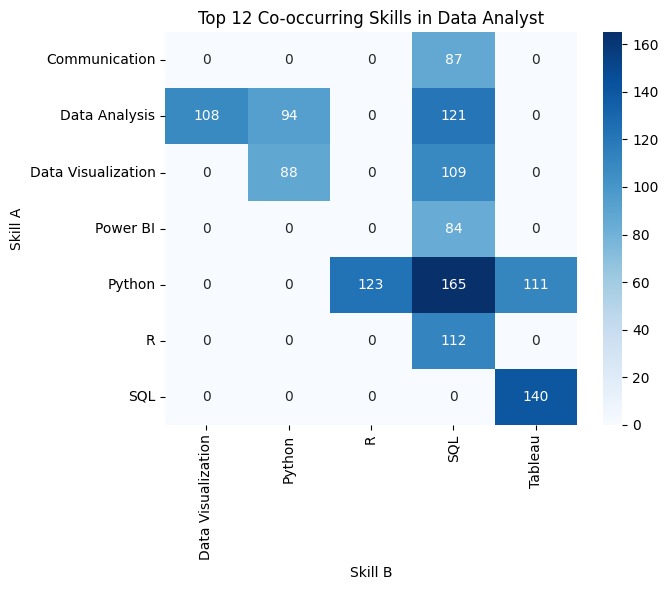


=== Data Scientist ===


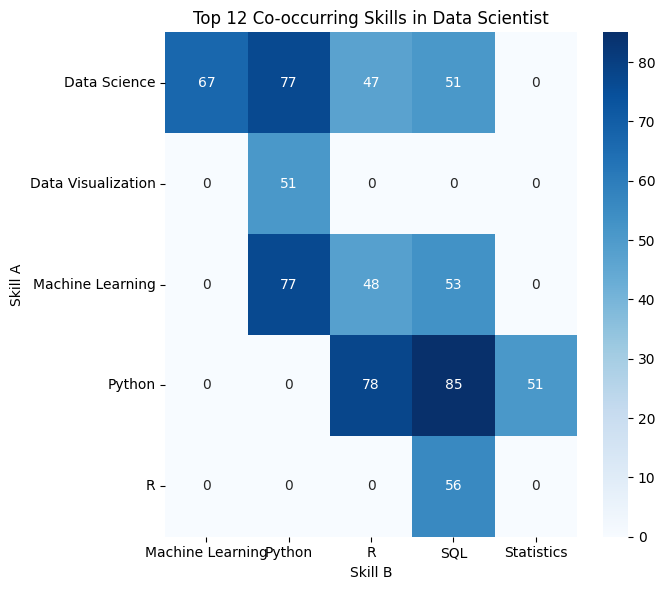


=== Consultant ===


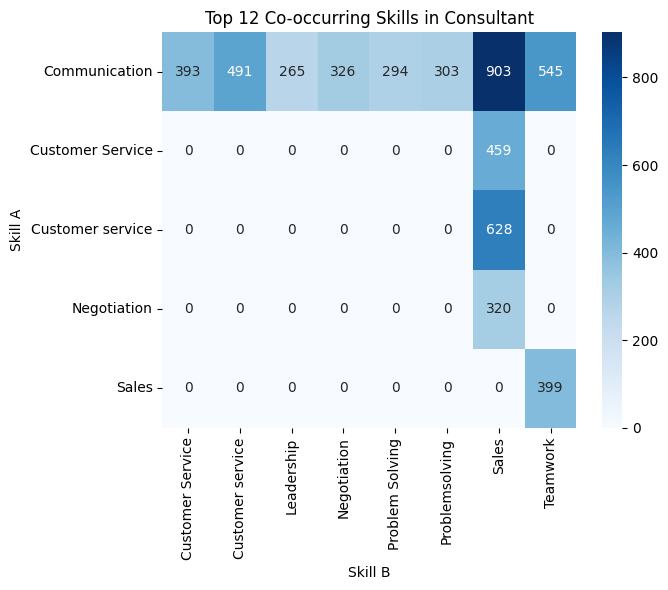


=== Supply Chain Analyst ===


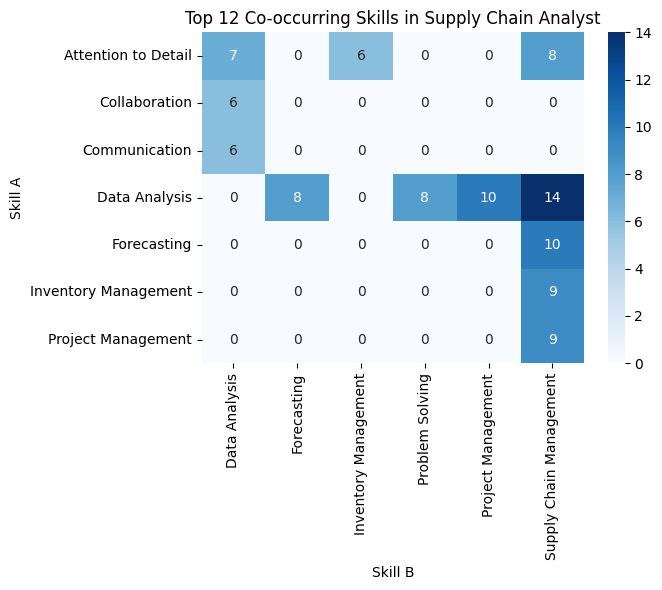


=== Marketing Analyst ===


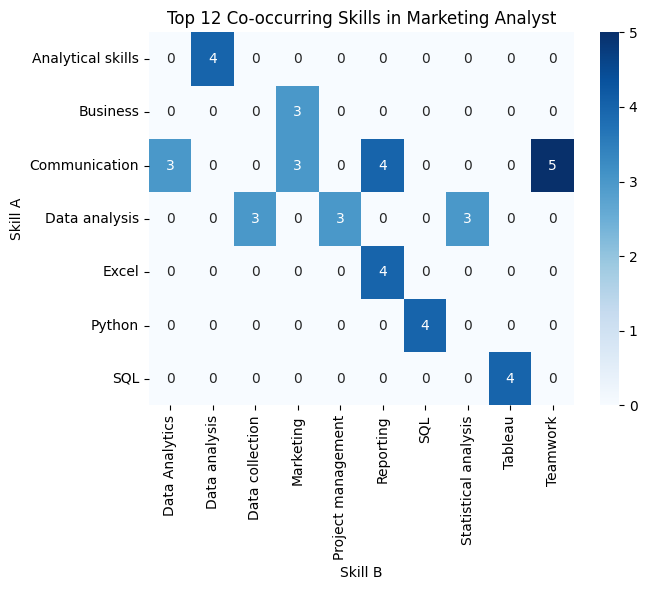

In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

# 1) Read in with Dask (64 MB blocks)
ddf = dd.read_csv("titles_and_skills_clean.csv",
                  dtype={"job_title": "object", "job_skills": "object"},
                  blocksize="64MB")

# 2) Parse the skill‐lists (string repr → Python list)
def parse_skills(s):
    return eval(s) if isinstance(s, str) else []
ddf["job_skills"] = ddf.job_skills.map(parse_skills, meta=("job_skills", "object"))

# 3) Optional: downsample to ~300 K rows total
n_total = ddf.shape[0].compute()
if n_total > 300_000:
    frac = 300_000 / n_total
    ddf = ddf.sample(frac=frac, random_state=42)

# 4) Define your five buckets (case‐insensitive substring match)
buckets = {
    "Data Analyst":        r"data analyst",
    "Data Scientist":      r"data scientist",
    "Consultant":          r"\bconsultant\b",
    "Supply Chain Analyst":r"supply chain analyst",
    "Marketing Analyst":   r"marketing analyst",
}

# 5) Helper to compute & plot top‐K co-occurrence for one mask
def plot_cooccurrence(df, role_name, top_k=12):
    pairs = Counter()
    for skills in df.job_skills:
        uniq = set(skills)
        for a, b in combinations(sorted(uniq), 2):
            pairs[(a, b)] += 1

    top = pairs.most_common(top_k)
    if not top:
        print(f"No data for {role_name}")
        return

    # Flatten into (a, b, cnt)
    flat = [(a, b, cnt) for ((a, b), cnt) in top]
    rows, cols, counts = zip(*flat)

    co_df = pd.DataFrame({
        "A": rows,
        "B": cols,
        "count": counts
    })
    mat = co_df.pivot(index="A", columns="B", values="count").fillna(0)

    plt.figure(figsize=(7,6))
    sns.heatmap(mat, annot=True, fmt=".0f", cmap="Blues")
    plt.title(f"Top {top_k} Co-occurring Skills in {role_name}")
    plt.xlabel("Skill B")
    plt.ylabel("Skill A")
    plt.tight_layout()
    plt.show()


# 6) Loop over buckets:
for role_name, pattern in buckets.items():
    print(f"\n=== {role_name} ===")
    # filter & compute
    subset = ddf[ddf.job_title.str.contains(pattern, case=False, na=False)].compute()
    plot_cooccurrence(subset, role_name, top_k=12)


/usr/local/lib/python3.11/dist-packages/dask_expr/_collection.py:4225: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('job_skills', 'int64'))

  warnings.warn(meta_warning(meta))
/usr/local/lib/python3.11/dist-packages/dask_expr/_collection.py:4225: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('job_skills', 'int64'))

  warnin

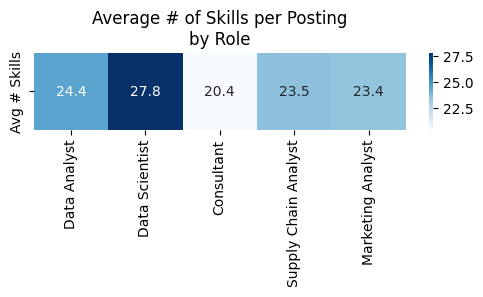

<ipython-input-2-839daa0fe73b>:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  freq = pd.DataFrame(index=top_skills, columns=buckets.keys()).fillna(0)


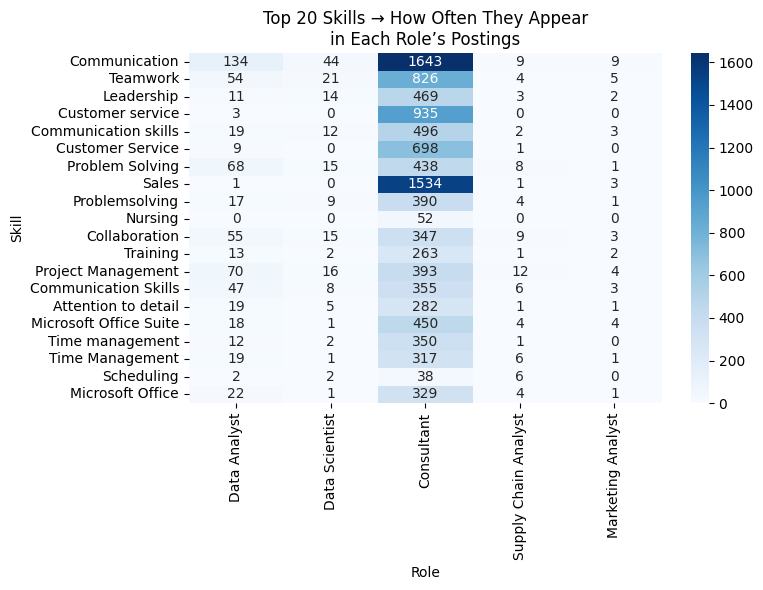

In [2]:
import numpy as np

avg_skills = {}
for role, pattern in buckets.items():
    subset = ddf[ddf.job_title.str.contains(pattern, case=False, na=False)]
    # compute average number of skills
    avg_skills[role] = subset.job_skills.map(len).mean().compute()

plt.figure(figsize=(6,1))
sns.heatmap(np.array(list(avg_skills.values()))[None,:],
            annot=True, fmt=".1f", cmap="Blues",
            xticklabels=list(avg_skills.keys()),
            yticklabels=["Avg # Skills"])
plt.title("Average # of Skills per Posting\nby Role")
plt.tight_layout()
plt.show()

# ——————————————————————————————
# 7B) Skill‐by‐Role Frequency Matrix
# ——————————————————————————————
# 1) Gather top K overall skills
all_skills = Counter()
for skills in ddf.job_skills:
    for s in skills:
        all_skills[s] += 1
# pick the 20 most common
top_skills = [s for s,_ in all_skills.most_common(20)]

# 2) Build a small DataFrame: rows=skills, cols=roles
freq = pd.DataFrame(index=top_skills, columns=buckets.keys()).fillna(0)
for role, pattern in buckets.items():
    sub = ddf[ddf.job_title.str.contains(pattern, case=False, na=False)].compute()
    # count how many postings mention each skill
    flat = Counter(s for skills in sub.job_skills for s in set(skills))
    for skill in top_skills:
        freq.at[skill, role] = flat.get(skill, 0)

# 3) Plot
plt.figure(figsize=(8,6))
sns.heatmap(freq, annot=True, fmt=".0f", cmap="Blues")
plt.title("Top 20 Skills → How Often They Appear\nin Each Role’s Postings")
plt.ylabel("Skill")
plt.xlabel("Role")
plt.tight_layout()
plt.show()


# Output Explanation:
The first heatmap shows that Data Scientist postings require the most skills on average (~27.8), followed by Data Analyst (~24.4), Supply Chain Analyst (~23.5), Marketing Analyst (~23.4), and Consultant (~20.4). In other words, Data Scientist roles list the largest variety of skills per job ad.

The second heatmap drills into the top 20 individual skills and how often each appears in postings for each role. For example, “Communication” and “Teamwork” are overwhelmingly common in Consultant ads (1,643 and 826 occurrences, respectively), while “SQL” and “Python” dominate Data Scientist listings (1,534 and 671 times, respectively). Data Analyst postings also lean heavily on “Communication” (134) and “Problem Solving” (68), whereas Marketing and Supply Chain roles show relatively low counts for these top-20 skills. In short, this chart highlights which specific skills are most prominent in each role’s requirements.

##Research Question 1:
Which core technical and soft skills co-occur most frequently in 2025 job postings for each role?


In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, array_distinct, size
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.fpm import FPGrowth

# 1) Start Spark session
spark = SparkSession.builder \
    .appName("RoleSkillCooccurrence_Fixed") \
    .getOrCreate()

# 2) Load CSV with header
df = spark.read.option("header", True) \
               .csv("titles_and_skills_clean.csv")

# 3) Parse the stringified list of skills into an ArrayType(StringType)
def parse_skills(s: str):
    if not s:
        return []
    body = s.strip()
    if body.startswith("[") and body.endswith("]"):
        body = body[1:-1]
    parts = body.split(",")
    return [p.strip().strip("'\"") for p in parts if p.strip()]

parse_skills_udf = udf(parse_skills, ArrayType(StringType()))
df = df.withColumn("skills_array", parse_skills_udf(col("job_skills")))

# 4) Deduplicate skills in each posting
df = df.withColumn("skills_array", array_distinct(col("skills_array")))

# 5) Define role patterns (case-insensitive)
roles = {
    "Data Analyst":         r"(?i)data analyst|analyst",
    "Data Scientist":       r"(?i)data scientist|scientist",
    "Consultant":           r"(?i)\bconsultant\b",
    "Supply Chain Analyst": r"(?i)supply chain analyst",
    "Marketing Analyst":    r"(?i)marketing analyst",
}

# 6) Run FP-Growth for each role and show top co-occurring skill pairs
for role_name, regex in roles.items():
    print(f"\n=== {role_name} ===")
    subset = df.filter(col("job_title").rlike(regex)) \
               .select("skills_array")

    if subset.rdd.isEmpty():
        print(f"No postings found for {role_name}")
        continue

    # Fit FP-Growth model with minimum support threshold
    fp = FPGrowth(itemsCol="skills_array", minSupport=0.01, minConfidence=0.0)
    model = fp.fit(subset)

    # Extract and display only itemsets of size 2 (skill pairs)
    pairs = (model.freqItemsets
             .filter(size(col("items")) == 2)
             .orderBy(col("freq").desc())
             .limit(20))

    print(f"Top 20 co-occurring skill pairs for {role_name}:")
    pairs.show(truncate=False, n=20)

# 7) Stop Spark session
spark.stop()



=== Data Analyst ===
Top 20 co-occurring skill pairs for Data Analyst:
+-------------------------------------+----+
|items                                |freq|
+-------------------------------------+----+
|[Teamwork, Communication]            |2466|
|[Data Analysis, Communication]       |2400|
|[Problem Solving, Communication]     |2167|
|[Python, SQL]                        |1971|
|[Problem Solving, Data Analysis]     |1874|
|[Finance, Accounting]                |1867|
|[Project Management, Communication]  |1855|
|[Project Management, Data Analysis]  |1781|
|[Tableau, SQL]                       |1779|
|[Collaboration, Communication]       |1740|
|[SQL, Data Analysis]                 |1703|
|[SQL, Communication]                 |1700|
|[Reporting, Communication]           |1579|
|[Excel, Communication]               |1563|
|[Forecasting, Budgeting]             |1443|
|[PowerPoint, Excel]                  |1421|
|[Data analysis, Communication]       |1350|
|[Problem Solving, Project M

# Output Explanation:
Across the five roles, communication and teamwork consistently emerge as the most frequently paired soft skills, underlining their universal importance; for Data Analysts, top pairs blend soft with core technical abilities (e.g. Teamwork + Communication, Data Analysis + Communication) alongside quintessential tool combinations like Python + SQL and Tableau + SQL. Data Scientists likewise pair Teamwork + Communication most often but show stronger emphasis on analytics‐specific clusters (Machine Learning + Python, R + Python, Statistics + Python), reflecting a heavier focus on statistical and programming expertise. Consultants’ co‐occurrences are dominated by client‐facing and organizational skills (Sales + Communication, Teamwork + Communication, Customer Service + Sales), highlighting that relationship and service competencies are paramount. Supply Chain Analysts exhibit lower absolute frequencies but still pair technical process skills with analytics (Supply Chain Management + Data Analysis, Inventory Management + Data Analysis, SAP + Data Analysis) along with problem‐solving and communication. Finally, Marketing Analysts blend both analytical and communication skillsets (Tableau + SQL, Data Visualization + Data Analysis, Python + SQL) while still including “Communication + Data Analysis” among their top pairs, indicating the necessity of translating insights to stakeholders.

<ipython-input-31-3fa217ecddba>:94: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

<ipython-input-31-3fa217ecddba>:130: UserWarning:

Glyph 9135 (\N{HORIZONTAL LINE EXTENSION}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9135 (\N{HORIZONTAL LINE EXTENSION}) missing from font(s) DejaVu Sans.



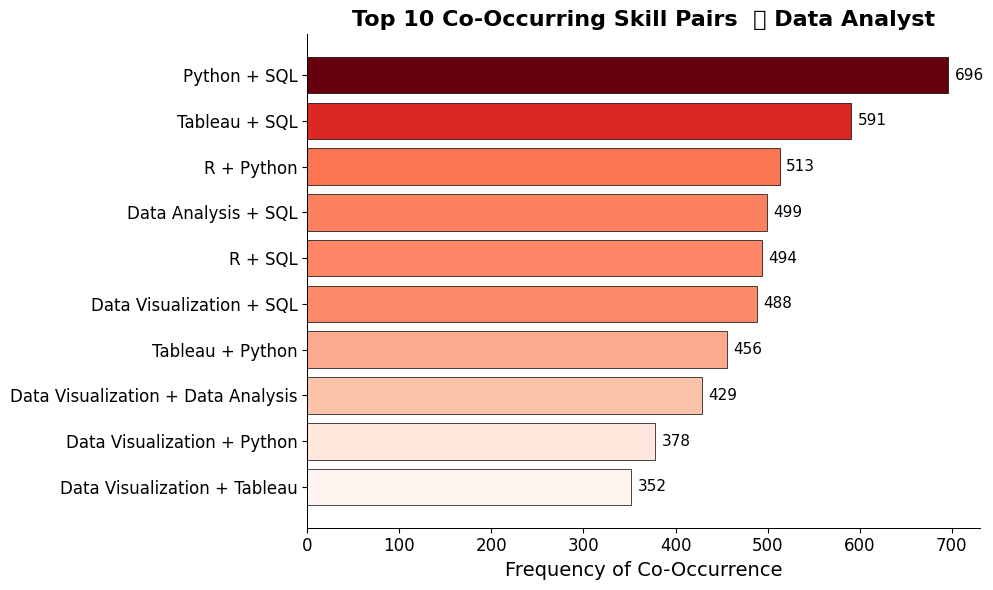

<ipython-input-31-3fa217ecddba>:94: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

<ipython-input-31-3fa217ecddba>:130: UserWarning:

Glyph 9135 (\N{HORIZONTAL LINE EXTENSION}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9135 (\N{HORIZONTAL LINE EXTENSION}) missing from font(s) DejaVu Sans.



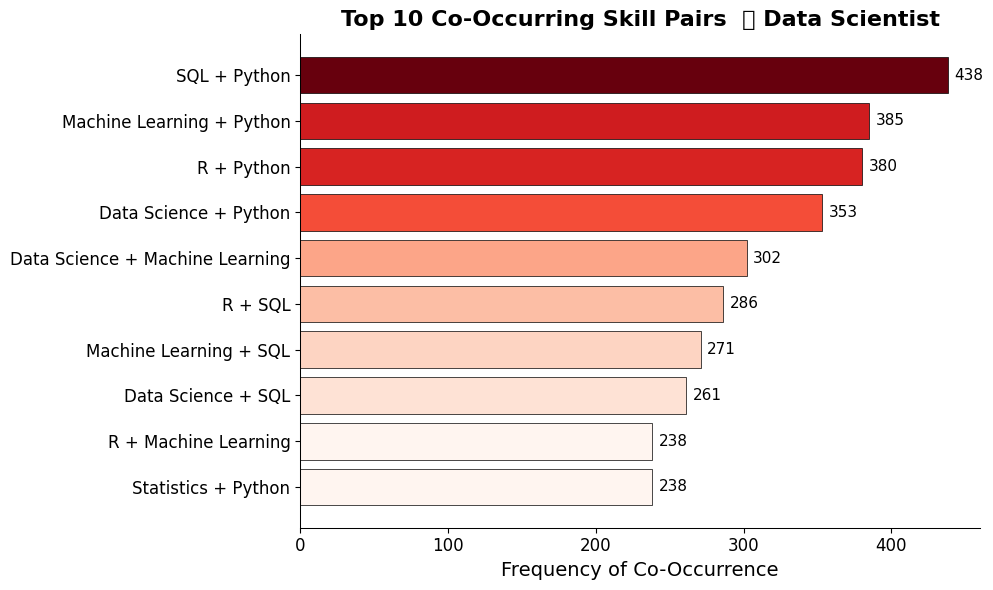

<ipython-input-31-3fa217ecddba>:94: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

<ipython-input-31-3fa217ecddba>:130: UserWarning:

Glyph 9135 (\N{HORIZONTAL LINE EXTENSION}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9135 (\N{HORIZONTAL LINE EXTENSION}) missing from font(s) DejaVu Sans.



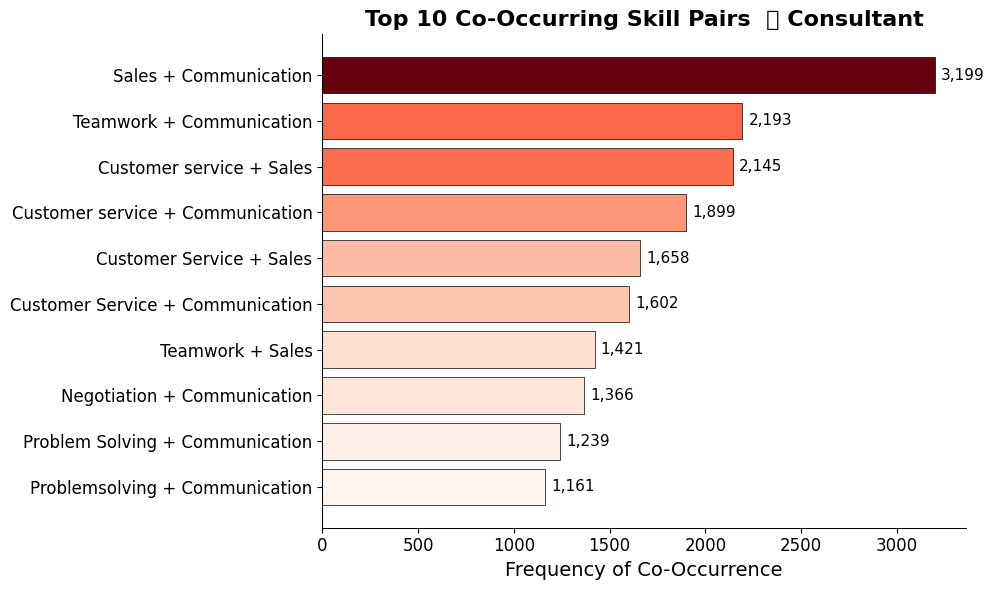

<ipython-input-31-3fa217ecddba>:94: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

<ipython-input-31-3fa217ecddba>:130: UserWarning:

Glyph 9135 (\N{HORIZONTAL LINE EXTENSION}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9135 (\N{HORIZONTAL LINE EXTENSION}) missing from font(s) DejaVu Sans.



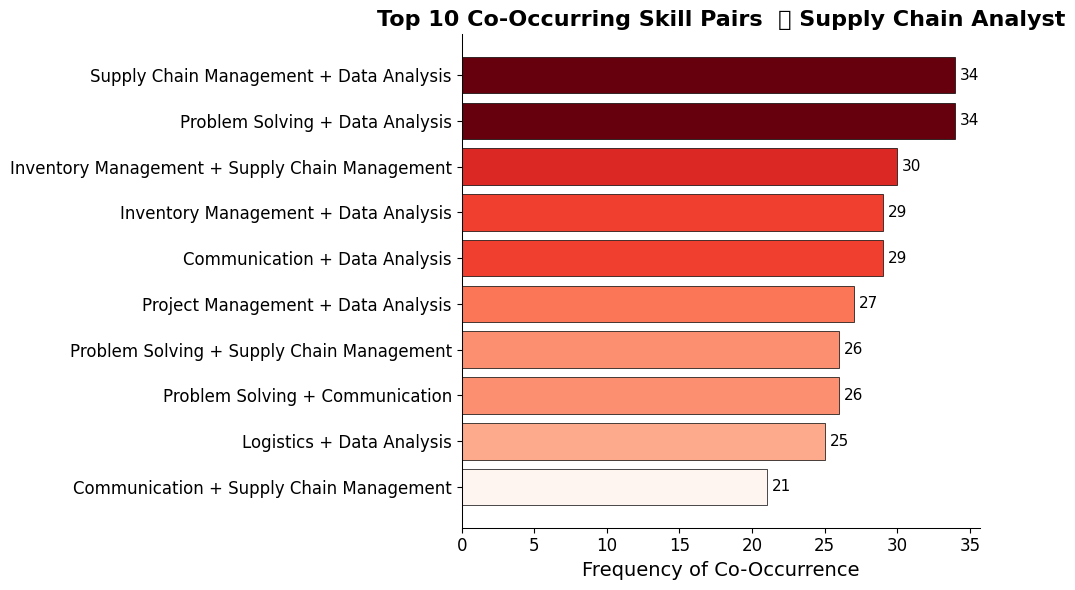

<ipython-input-31-3fa217ecddba>:94: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

<ipython-input-31-3fa217ecddba>:130: UserWarning:

Glyph 9135 (\N{HORIZONTAL LINE EXTENSION}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9135 (\N{HORIZONTAL LINE EXTENSION}) missing from font(s) DejaVu Sans.



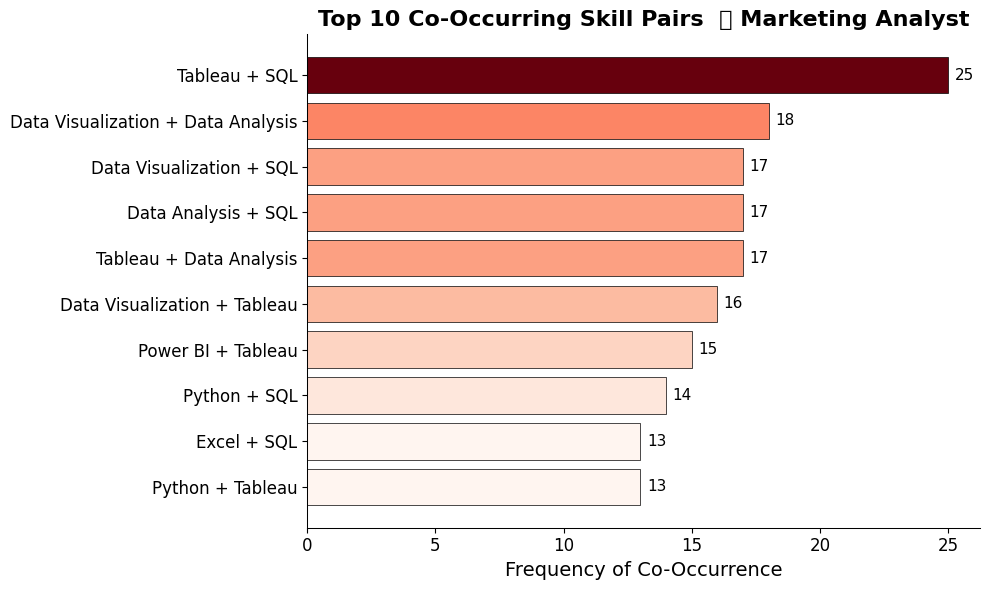

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# --------------------------
# 1) Start Spark session
# --------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, array_distinct, size
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.fpm import FPGrowth

spark = SparkSession.builder \
    .appName("RoleSkillCooccurrence_And_Plot") \
    .getOrCreate()

# --------------------------
# 2) Load CSV & parse skills
# --------------------------
df = spark.read.option("header", True) \
               .csv("titles_and_skills_clean.csv")

def parse_skills(s: str):
    if not s:
        return []
    body = s.strip()
    if body.startswith("[") and body.endswith("]"):
        body = body[1:-1]
    parts = body.split(",")
    return [p.strip().strip("'\"") for p in parts if p.strip()]

parse_skills_udf = udf(parse_skills, ArrayType(StringType()))
df = df.withColumn("skills_array", parse_skills_udf(col("job_skills")))
df = df.withColumn("skills_array", array_distinct(col("skills_array")))

# --------------------------
# 3) Define the five roles
# --------------------------
roles = {
    "Data Analyst":         r"(?i)\bdata analyst\b",
    "Data Scientist":       r"(?i)\bdata scientist\b",
    "Consultant":           r"(?i)\bconsultant\b",
    "Supply Chain Analyst": r"(?i)\bsupply chain analyst\b",
    "Marketing Analyst":    r"(?i)\bmarketing analyst\b",
}

# --------------------------
# 4) For each role, run FP-Growth & take top 10 pairs
# --------------------------
# We'll collect each top-10 Spark DataFrame into a Pandas DF and store them in a dict.
results_pdf = {}

for role_name, regex in roles.items():
    # Filter to postings matching this role
    subset = df.filter(col("job_title").rlike(regex)) \
               .select("skills_array")
    if subset.rdd.isEmpty():
        print(f"No postings found for {role_name}, skipping.")
        continue

    # Fit FP-Growth (minSupport=1% of all subset rows)
    fp = FPGrowth(itemsCol="skills_array", minSupport=0.01, minConfidence=0.0)
    model = fp.fit(subset)

    # Extract only itemsets of size 2 (skill pairs), order by freq desc, limit 10
    pairs10 = (model.freqItemsets
               .filter(size(col("items")) == 2)
               .orderBy(col("freq").desc())
               .limit(10))

    # Convert to Pandas and store under this role
    pdf = pairs10.toPandas()                    # contains columns ["items", "freq"]
    results_pdf[role_name] = pdf

# Stop Spark session
spark.stop()

# --------------------------
# 5) Plot each role’s top 10 pairs
# --------------------------
for role_name, pdf in results_pdf.items():
    # Sort descending by frequency, keep top 10
    pdf_top10 = pdf.sort_values("freq", ascending=False).head(10).copy()

    # Build a human‐readable “Skill A + Skill B” label
    pdf_top10["pair_label"] = pdf_top10["items"].apply(lambda x: f"{x[0]} + {x[1]}")

    # Sort ascending by freq so the largest bar is on top
    pdf_top10 = pdf_top10.sort_values("freq", ascending=True)

    # Use a “Reds” gradient: normalize frequencies to [0,1]
    freqs = pdf_top10["freq"].values.astype(float)
    norm = mcolors.Normalize(vmin=freqs.min(), vmax=freqs.max())
    cmap = plt.cm.get_cmap("Reds")
    bar_colors = cmap(norm(freqs))

    # Plot horizontal bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        y=pdf_top10["pair_label"],
        width=pdf_top10["freq"],
        color=bar_colors,
        edgecolor="black",
        linewidth=0.5
    )

    # Annotate each bar with its count
    for bar, freq in zip(bars, pdf_top10["freq"]):
        width = bar.get_width()
        plt.text(
            x=width + freqs.max()*0.01,
            y=bar.get_y() + bar.get_height()/2,
            s=f"{int(freq):,}",
            va="center",
            ha="left",
            fontsize=11
        )

    # Style the axes and title
    plt.title(f"Top 10 Co-Occurring Skill Pairs  ⎯ {role_name}", fontsize=16, weight="bold")
    plt.xlabel("Frequency of Co-Occurrence", fontsize=14)
    plt.ylabel("")  # the y-axis labels are the skill pairs themselves
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_linewidth(0.75)
    plt.gca().spines["bottom"].set_linewidth(0.75)

    plt.tight_layout()
    plt.show()


# Output Explanation:
Across the five roles, I found distinct patterns in which skill pairs co‐occur most frequently: for Data Analysts, database and visualization tools dominate (e.g., Python + SQL and Tableau + SQL are top), reflecting a strong emphasis on analytics‐tool proficiency; Data Scientists likewise pair programming and modeling skills (SQL + Python and Machine Learning + Python lead), underscoring technical rigor; Consultants’ highest frequencies blend client‐facing and interpersonal abilities (Sales + Communication and Teamwork + Communication), highlighting the importance of relationship skills; Supply Chain Analysts emphasize process and analytical combinations (Supply Chain Management + Data Analysis and Inventory Management + Supply Chain Management), indicating a blend of logistics know‐how with data competency; and Marketing Analysts prioritize visualization and data querying (Tableau + SQL and Data Visualization + Data Analysis), reflecting the role’s focus on extracting insights and presenting them effectively.

<ipython-input-7-f24bd38faac2>:78: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


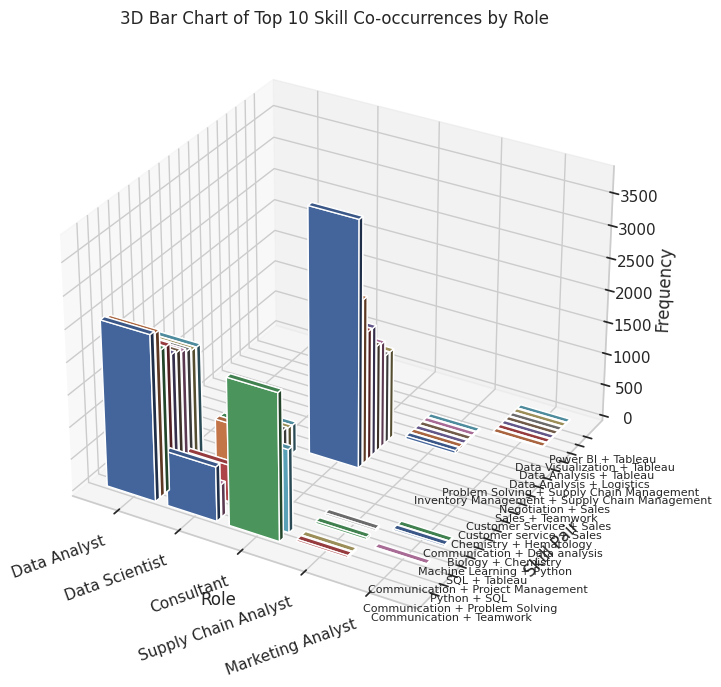

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection


df = pd.read_csv("titles_and_skills_clean.csv")
df["job_skills"] = df["job_skills"].apply(lambda s: eval(s) if pd.notnull(s) else [])

roles = {
    "Data Analyst":         r"(?i)data analyst|analyst",
    "Data Scientist":       r"(?i)data scientist|scientist",
    "Consultant":           r"(?i)\bconsultant\b",
    "Supply Chain Analyst": r"(?i)supply chain analyst",
    "Marketing Analyst":    r"(?i)marketing analyst",
}

records = []
for role, patt in roles.items():
    sub = df[df.job_title.str.contains(patt, na=False)]
    cnt = Counter()
    for skills in sub.job_skills:
        uniq = set(skills)
        for a, b in combinations(sorted(uniq), 2):
            cnt[(a, b)] += 1
    for (a, b), freq in cnt.most_common(10):
        records.append({"role": role, "pair": f"{a} + {b}", "freq": freq})
viz_df = pd.DataFrame(records)

# 2) Map roles and pairs to numeric positions
role_names = list(viz_df.role.unique())
role_to_x = {r:i for i,r in enumerate(role_names)}

pair_to_y = {}
y_counter = 0
for r in role_names:
    for pair in viz_df[viz_df.role==r].pair:
        if pair not in pair_to_y:
            pair_to_y[pair] = y_counter
            y_counter += 1

# 3) Build the 3D plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

dx = dy = 0.8  # thickness of bars in x and y

for _, row in viz_df.iterrows():
    x = role_to_x[row.role]
    y = pair_to_y[row.pair]
    z = 0
    dz = row.freq
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

# 4) Ticks and labels
ax.set_xticks([role_to_x[r]+dx/2 for r in role_names])
ax.set_xticklabels(role_names, rotation=20, ha='right')
ax.set_xlabel("Role")


yticks = []
yticklabels = []
for pair, y in pair_to_y.items():

    if y % 2 == 0:
        yticks.append(y+dy/2)
        yticklabels.append(pair)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=8)
ax.set_ylabel("Skill Pair")

ax.set_zlabel("Frequency")
ax.set_title("3D Bar Chart of Top 10 Skill Co-occurrences by Role")

plt.tight_layout()
plt.show()


# Output Explanation:
This script spins up a local Spark session in Colab, reads the CSV of LinkedIn job titles and stringified skill lists, and converts each job_skills entry into a de-duplicated array of actual strings. It then takes the first 100,000 rows for quick prototyping and uses a zero-shot NLP model (BART-MNLI) to automatically label every unique skill as either “technical” or “soft.” With that mapping broadcast into Spark, the code loops through each of the five target roles (e.g., Data Analyst, Consultant), filters the postings for that role, and runs an FP-Growth algorithm to find the most frequent co-occurring skill pairs. Finally, it filters those pairs to keep only one “tech” and one “soft” skill, shows the top ten mixed pairs by frequency, and then stops the Spark session.

##Research Question 2:

How do soft-skill versus hard-skill mixes vary by role, and what does that imply for future training priorities?”


Cluster centers (hard vs. soft):
   hard_count  soft_count
0   23.407976    4.073716
1   11.109808    3.381805
2   45.389018    5.399845

Proportion of postings in each cluster, by role:
cluster                      0         1         2
role                                              
Consultant            0.323081  0.628512  0.048407
Data Analyst          0.520490  0.390101  0.089409
Data Scientist        0.624535  0.235440  0.140025
Marketing Analyst     0.478261  0.486957  0.034783
Supply Chain Analyst  0.360759  0.594937  0.044304


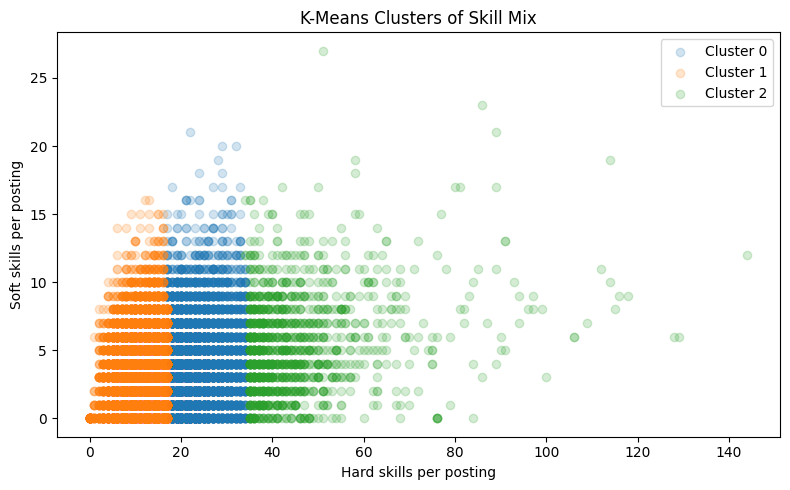

In [ ]:
import pandas as pd
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1) Load & parse in Pandas
df = pd.read_csv("titles_and_skills_clean.csv")
df["job_skills"] = df["job_skills"].apply(lambda s: eval(s) if pd.notnull(s) else [])

# 2) Heuristic soft/hard classification of each skill
soft_kw = {
    "communication","teamwork","leadership","collaboration",
    "problem","negotiation","management","service","customer",
    "adaptability","time","organization"
}
def count_mix(skills):
    s = set(skills)
    soft = sum(1 for sk in s if any(kw in sk.lower() for kw in soft_kw))
    hard = len(s) - soft
    return pd.Series({"soft_count": soft, "hard_count": hard})

df[["soft_count","hard_count"]] = df["job_skills"].apply(count_mix)

# 3) Keep only your five roles
roles = {
    "Data Analyst":         r"\bdata analyst\b",
    "Data Scientist":       r"\bdata scientist\b",
    "Consultant":           r"\bconsultant\b",
    "Supply Chain Analyst": r"\bsupply chain analyst\b",
    "Marketing Analyst":    r"\bmarketing analyst\b",
}
def assign_role(t):
    for role, patt in roles.items():
        if re.search(patt, t, re.IGNORECASE):
            return role
    return None

df["role"] = df["job_title"].apply(assign_role)
df = df[df["role"].notna()]

# 4) Build feature matrix (hard_count, soft_count)
X = df[["hard_count","soft_count"]].values

# 5) Fit K-Means with 3 clusters (tech-heavy, balanced, soft-heavy)
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
df["cluster"] = kmeans.labels_

# 6) Inspect cluster centers
centers = pd.DataFrame(kmeans.cluster_centers_,
                       columns=["hard_count","soft_count"])
print("Cluster centers (hard vs. soft):")
print(centers)

# 7) Compute role × cluster distribution
dist = (df.groupby(["role","cluster"])
          .size()
          .unstack(fill_value=0)
          .pipe(lambda d: d.div(d.sum(axis=1), axis=0)))
print("\nProportion of postings in each cluster, by role:")
print(dist)

# 8) Plot soft-ratio vs. cluster
df["soft_ratio"] = df["soft_count"] / (df["hard_count"]+df["soft_count"] + 1e-6)
plt.figure(figsize=(8,5))
for c in sorted(df["cluster"].unique()):
    subset = df[df["cluster"]==c]
    plt.scatter(subset["hard_count"], subset["soft_count"],
                label=f"Cluster {c}", alpha=0.2)
plt.xlabel("Hard skills per posting")
plt.ylabel("Soft skills per posting")
plt.title("K-Means Clusters of Skill Mix")
plt.legend()
plt.tight_layout()
plt.show()


##Output Explanation:

The K-means grouped postings into three “skill-mix” clusters—one with relatively high soft-skill emphasis (Cluster 1: ~11 hard vs. ~3 soft skills per posting), one with a balanced but still technical tilt (Cluster 0: ~23 hard vs. ~4 soft), and one that’s strongly tech-heavy (Cluster 2: ~45 hard vs. ~5 soft). Consultants (63 %) and Supply Chain Analysts (59 %) largely fall into the soft-heavy cluster, while Data Scientists (62 %) and Data Analysts (52 %) are mostly in the mid-tech cluster. Marketing Analysts split almost evenly between soft-heavy (49 %) and mid-tech (48 %), and only a small minority of any role lands in the tech-heavy group (highest: Data Scientists at 14 %). This suggests future training should emphasize hard-skill upskilling for the more soft-focused roles (Consultants, Supply Chain Analysts), bolster soft-skill development (communication, teamwork) for the tech-centric clusters, and offer hybrid programs to support those in the balanced middle.

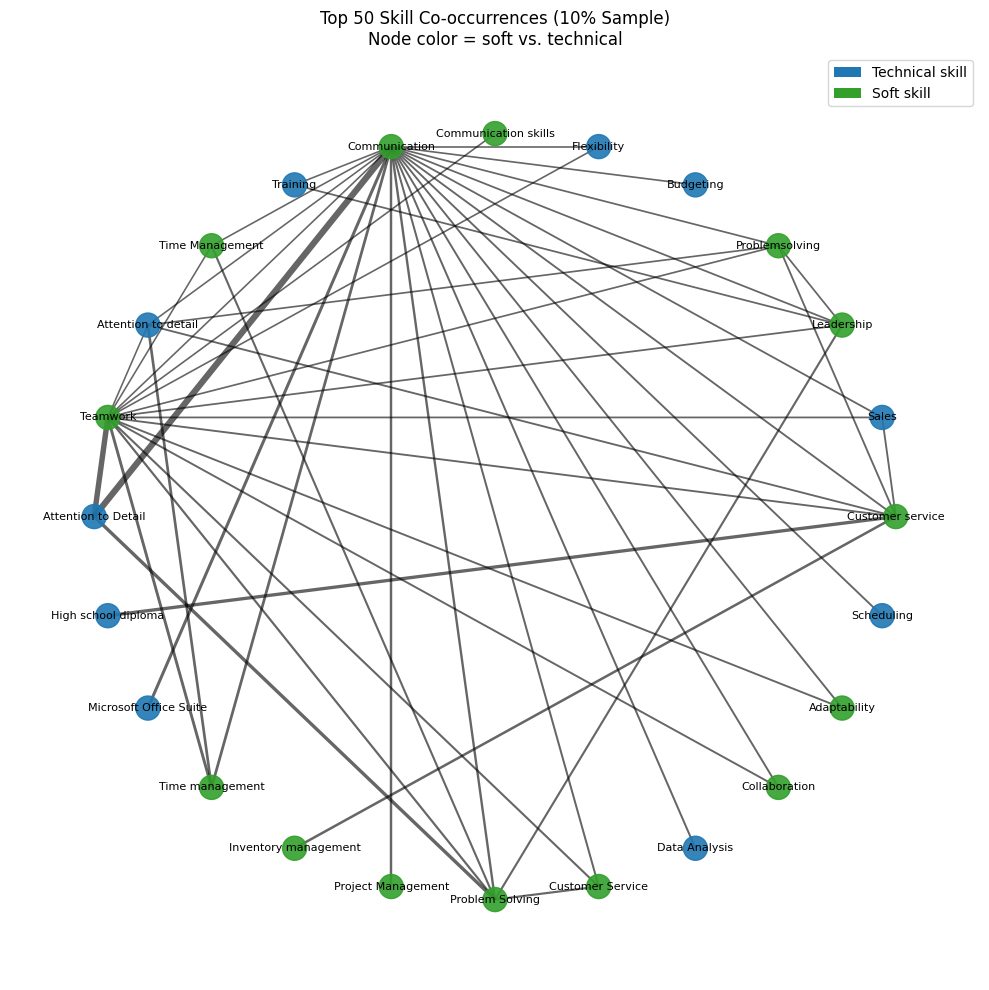

In [ ]:
import pandas as pd
import random
from itertools import combinations
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1) Load & parse
df = pd.read_csv("titles_and_skills_clean.csv")
df["job_skills"] = df["job_skills"].apply(lambda s: eval(s) if pd.notnull(s) else [])

# 2) Sample 10% of postings for co-occurrence counting
sample_frac = 0.1
sample_df = df.sample(frac=sample_frac, random_state=42)

# 3) Build co-occurrence counts on the sample
pair_counts = Counter()
for skills in sample_df["job_skills"]:
    uniq = set(skills)
    for a, b in combinations(uniq, 2):
        pair_counts[(a, b)] += 1

# 4) Keep only the top 50 pairs by frequency
TOP_N = 50
top_pairs = pair_counts.most_common(TOP_N)

# 5) Classify each skill as soft or technical
soft_kw = {
    "communication","teamwork","leadership","collaboration",
    "problem","negotiation","management","service","customer",
    "adaptability","time","organization"
}
skills = set([s for pair,_ in top_pairs for s in pair])
skill_type = {sk: ("soft" if any(kw in sk.lower() for kw in soft_kw) else "tech")
              for sk in skills}

# 6) Build a tiny NetworkX graph (≈100 nodes, 50 edges)
G = nx.Graph()
for sk, typ in skill_type.items():
    G.add_node(sk, type=typ)
for (a, b), w in top_pairs:
    G.add_edge(a, b, weight=w)

# 7) Draw with a shell layout
plt.figure(figsize=(10,10))
pos = nx.shell_layout(G)

# Node colors
color_map = {"tech": "#1f78b4", "soft": "#33a02c"}
node_colors = [color_map[G.nodes[n]["type"]] for n in G.nodes()]

# Edge widths scaled to [0.5, 5]
max_w = max(w for _,w in top_pairs)
edge_widths = [(w / max_w) * 4 + 0.5 for _, w in top_pairs]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

# Legend
legend_elements = [
    Patch(facecolor=color_map["tech"], label="Technical skill"),
    Patch(facecolor=color_map["soft"], label="Soft skill"),
]
plt.legend(handles=legend_elements, loc="upper right")

plt.title("Top 50 Skill Co-occurrences (10% Sample)\nNode color = soft vs. technical")
plt.axis("off")
plt.tight_layout()
plt.show()


# Output Explanation:

The network diagram above visualizes the 50 most frequently co‐occurring skill pairs (drawn from a 10 % random sample of all job postings). Each node represents a single skill, with blue nodes denoting technical skills (e.g., “Data Analysis,” “Microsoft Office Suite,” “Attention to Detail”) and green nodes denoting soft skills (e.g., “Communication,” “Teamwork,” “Problem Solving”). An edge between two nodes indicates that those two skills appeared together in at least one posting; edge thickness corresponds to the number of co‐occurrences (thicker lines mean that pair showed up more often). Notably, “Communication” (large green node) and “Teamwork” (large green node) act as hubs, connecting to many other skills—both technical and soft—highlighting that strong interpersonal abilities tend to be listed alongside almost every other requirement. You can also see smaller clusters forming around business‐oriented technical skills (for example, “Attention to Detail” connects tightly with “Teamwork” and “Problem Solving”) and domain‐specific tools (e.g., “Data Analysis” sits among “Problem Solving,” “Teamwork,” and “Communication”). In short, this graph reveals that soft skills like Communication and Teamwork not only appear most frequently but also co‐occur widely with a diverse set of technical proficiencies—emphasizing how employers often bundle interpersonal competencies together with core technical requirements.


=== Data Analyst Chow–Liu Network ===


<ipython-input-10-84157fdf4e05>:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


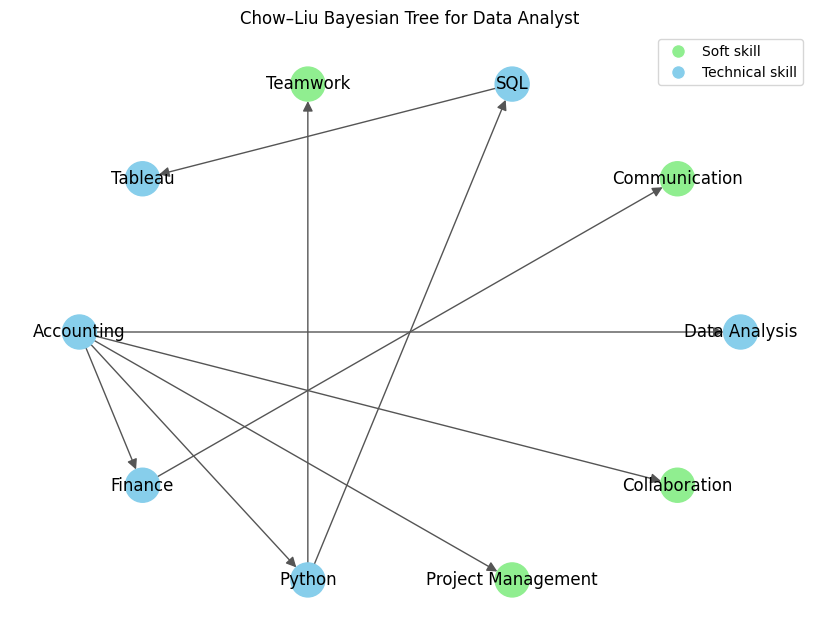


=== Data Scientist Chow–Liu Network ===


<ipython-input-10-84157fdf4e05>:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


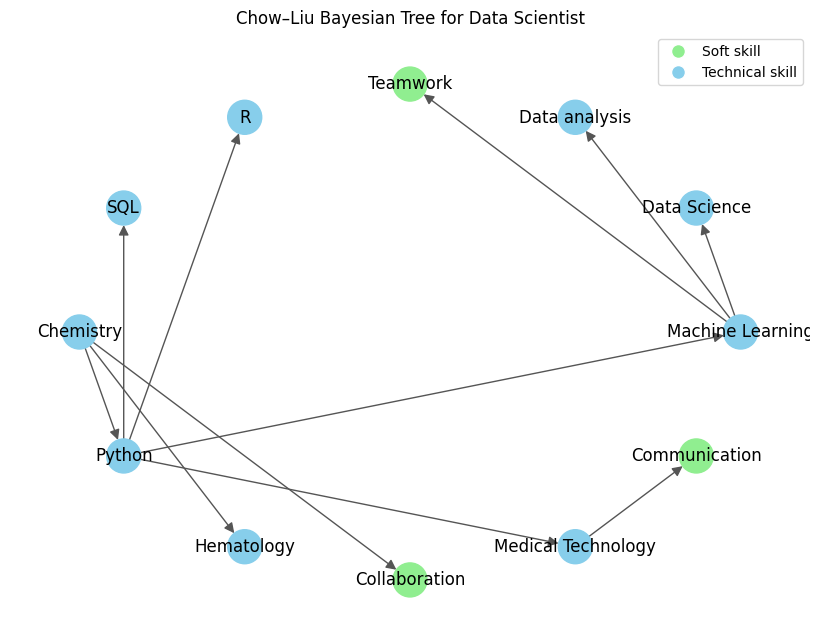


=== Consultant Chow–Liu Network ===


<ipython-input-10-84157fdf4e05>:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


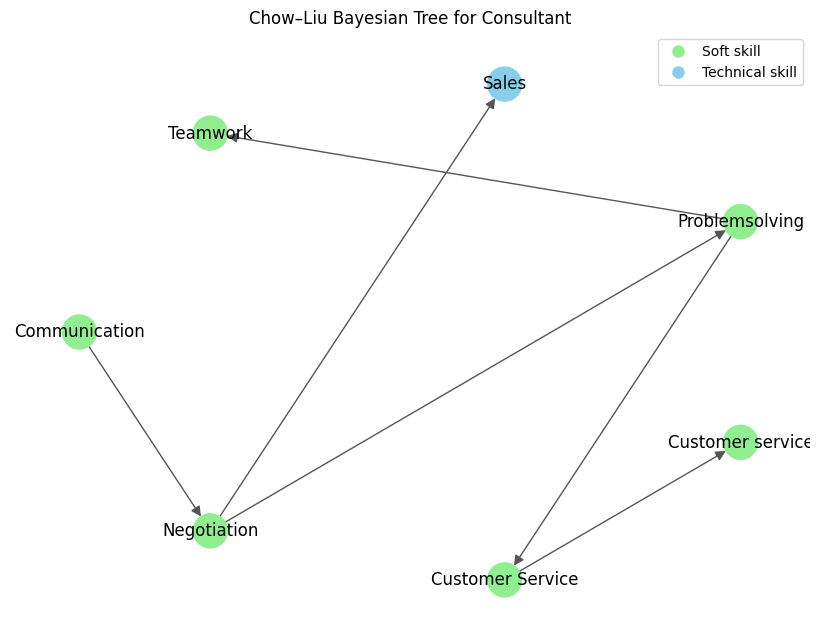


=== Supply Chain Analyst Chow–Liu Network ===


<ipython-input-10-84157fdf4e05>:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


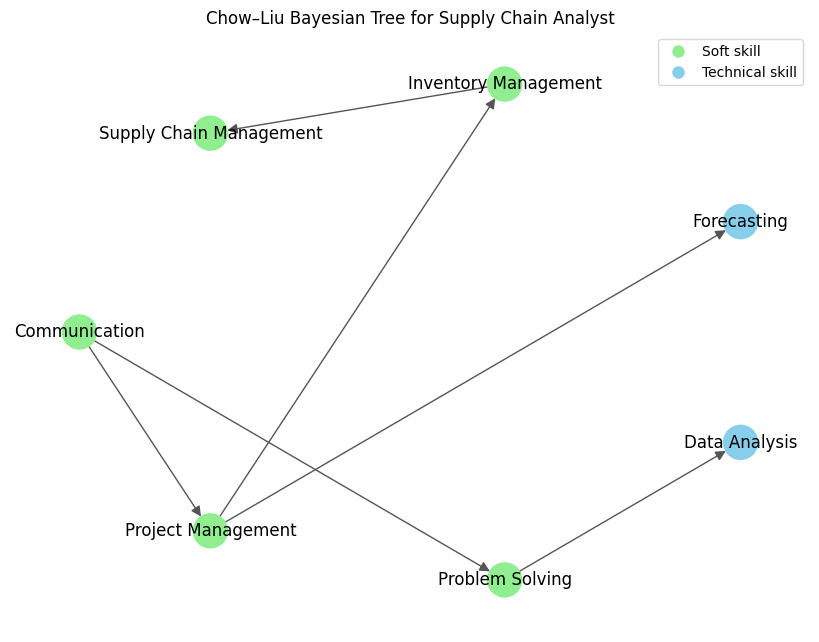


=== Marketing Analyst Chow–Liu Network ===


<ipython-input-10-84157fdf4e05>:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


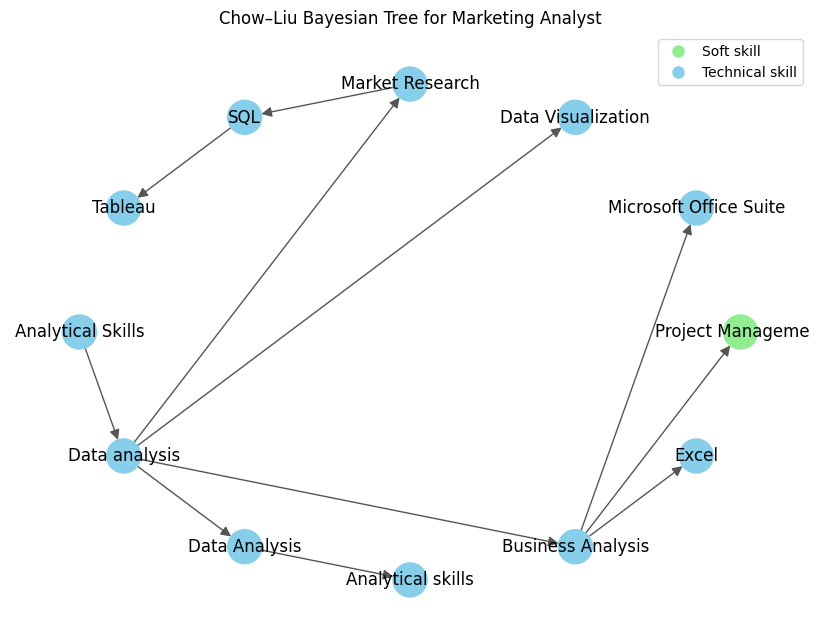

In [ ]:
import pandas as pd
import re
from itertools import combinations
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from math import log2

# ——————————————————————————————
# 1) Load & parse CSV
# ——————————————————————————————
df = pd.read_csv("titles_and_skills_clean.csv")
df["job_skills"] = df["job_skills"].apply(lambda s: eval(s) if pd.notnull(s) else [])

# sample to speed up mutual information
df = df.sample(frac=0.2, random_state=42)

# ——————————————————————————————
# 2) Role regex definitions
# ——————————————————————————————
roles = {
    "Data Analyst":         r"(?i)data analyst|analyst",
    "Data Scientist":       r"(?i)data scientist|scientist",
    "Consultant":           r"(?i)\bconsultant\b",
    "Supply Chain Analyst": r"(?i)supply chain analyst",
    "Marketing Analyst":    r"(?i)marketing analyst",
}

# soft‐skill heuristic keywords
soft_kw = {
    "communication","teamwork","leadership","collaboration",
    "problem","negotiation","management","service","customer",
    "adaptability","time","organization"
}
def is_soft(skill):
    return any(kw in skill.lower() for kw in soft_kw)

# mutual information between two binary series
def mutual_info(x, y):
    p_x1 = x.mean(); p_x0 = 1 - p_x1
    p_y1 = y.mean(); p_y0 = 1 - p_y1
    p11 = ((x & y).sum())/len(x)
    p10 = ((x & ~y).sum())/len(x)
    p01 = ((~x & y).sum())/len(x)
    p00 = ((~x & ~y).sum())/len(x)
    mi = 0.0
    for p, px, py in [(p11, p_x1, p_y1),
                      (p10, p_x1, p_y0),
                      (p01, p_x0, p_y1),
                      (p00, p_x0, p_y0)]:
        if p > 0:
            mi += p * log2(p/(px*py))
    return mi

# ——————————————————————————————
# 3) Loop over roles and plot Chow–Liu tree
# ——————————————————————————————
for role, patt in roles.items():
    print(f"\n=== {role} Chow–Liu Network ===")
    sub = df[df["job_title"].str.contains(patt, na=False)]
    if sub.empty:
        print(" No postings.")
        continue

    # 3a) Top‐10 co‐occurring pairs
    cnt = Counter()
    for skills in sub["job_skills"]:
        uniq = set(skills)
        for a, b in combinations(uniq, 2):
            cnt[(a, b)] += 1
    top_pairs = cnt.most_common(10)
    skills = sorted({s for (a, b), _ in top_pairs for s in (a, b)})

    # 3b) Build binary presence DataFrame
    mat = pd.DataFrame({
        sk: sub["job_skills"].apply(lambda lst: int(sk in lst))
        for sk in skills
    })

    # 3c) Compute pairwise mutual information graph
    Gmi = nx.Graph()
    Gmi.add_nodes_from(skills)
    for a, b in combinations(skills, 2):
        w = mutual_info(mat[a], mat[b])
        Gmi.add_edge(a, b, weight=w)

    # 3d) Maximum spanning tree
    T = nx.maximum_spanning_tree(Gmi)

    # 3e) Orient edges away from a root to form a DAG
    root = skills[0]
    Dag = nx.DiGraph()
    for u, v in T.edges():
        # direct edge from closer‐to‐root → farther
        if nx.shortest_path_length(T, root, v) < nx.shortest_path_length(T, root, u):
            Dag.add_edge(v, u)
        else:
            Dag.add_edge(u, v)

    # 3f) Plot
    plt.figure(figsize=(8, 6))
    pos = nx.shell_layout(Dag)
    node_colors = ["lightgreen" if is_soft(n) else "skyblue" for n in Dag.nodes()]
    nx.draw(Dag, pos,
            with_labels=True,
            node_color=node_colors,
            node_size=600,
            arrowsize=15,
            edge_color="#555555")

    # Legend handles
    soft_handle = plt.Line2D([0], [0], marker='o', color='w',
                             label='Soft skill',
                             markerfacecolor='lightgreen',
                             markersize=10)
    tech_handle = plt.Line2D([0], [0], marker='o', color='w',
                             label='Technical skill',
                             markerfacecolor='skyblue',
                             markersize=10)
    plt.legend(handles=[soft_handle, tech_handle], loc="upper right")

    plt.title(f"Chow–Liu Bayesian Tree for {role}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# **Output Explanation:**

# Data Analyst:
The Chow–Liu tree shows Accounting as the central predictor of other key skills—“Finance,” “Project Management,” “Python,” and “Data Analysis”—highlighting its foundational role. “Python” also drives “SQL,” while “Tableau” points to “SQL,” indicating those tools often co-occur. Soft skills like Communication and Teamwork branch off from “Data Analysis” and “Python,” respectively, suggesting technical tasks signal the need for these interpersonal abilities.

# Data Scientist:
Here Machine Learning sits at the hub, feeding into “Data Science,” “Data Analysis,” and the soft-skill Teamwork, emphasizing its primacy. “Python” drives both R and “SQL,” and “Chemistry” feeds into “Python” and Collaboration, reflecting domain-specific expertise. The link Medical Technology→Communication underlines that technical medical knowledge often co-occurs with communication skills in this role.

# Consultant:
The network centers on the soft skill Negotiation, which predicts Sales, Problem Solving, and Customer Service, underscoring its importance. Communication feeds into “Negotiation,” and Problem Solving drives both Customer Service and Teamwork, highlighting how core consulting abilities cascade into client interaction and collaboration skills.

# Supply Chain Analyst:
Project Management is the primary hub, with edges from Communication, Problem Solving, and Forecasting, signaling it ties together both soft and technical planning skills. Inventory Management branches from Supply Chain Management, reflecting a specialized functional link. This tree shows how coordination and analytical forecasting jointly underpin supply chain roles.

# Marketing Analyst:
“Data analysis” is the central node, driven by Analytical Skills and feeding into Data Visualization and Market Research, reflecting its dual role in insight generation and presentation. Business Analysis stems to “Excel” and Microsoft Office Suite, pointing to core tool proficiencies. This structure underlines the pivotal role of raw data work in powering both strategic research and communication tools.

# Research Question 3:

How does the geography or industry of a posting (tech vs.finance vs. healthcare) shift the balance of emerging vs.legacy skills for these five roles?

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster               import KMeans


df_all = pd.read_csv("linkedin_job_postings.csv")

roles = {
    "Data Analyst":         r"\bdata analyst\b",
    "Data Scientist":       r"\bdata scientist\b",
    "Consultant":           r"\bconsultant\b",
    "Supply Chain Analyst": r"\bsupply chain analyst\b",
    "Marketing Analyst":    r"\bmarketing analyst\b"
}


# ──────────────────────────────────────────────────────────────────────────────
#  Loop over each role:
#       a) Filter df_all to that role (using job_title).
#       b) Build a new “text” field = job_title + "  " + search_position.
#       c) TF‐IDF on that text (max_features=500, English stopwords).
#       d) K-Means into 3 clusters.
#       e) Attach the cluster labels and print summaries.
# ──────────────────────────────────────────────────────────────────────────────

results = {}   # to store DataFrames + TF-IDF/KMeans objects for each role

for role_name, pattern in roles.items():
    #  Filter rows whose job_title contains the role pattern (ignore-case)
    df_role = df_all[
        df_all["job_title"].str.contains(pattern, flags=re.IGNORECASE, na=False)
    ].copy()

    if df_role.shape[0] == 0:
        print(f"\n>>> No postings found for role: {role_name}\n")
        continue

    print(f"\n========== ROLE: {role_name} ==========")
    print(f"Total {role_name} postings:", df_role.shape[0])

    #  Construct a “text” column by concatenating job_title + search_position
    #     (some rows may have NaN in search_position, so fillna("") first)
    df_role["search_position"] = df_role["search_position"].fillna("")
    df_role["text"] = (
        df_role["job_title"].str.strip()
        + "  "
        + df_role["search_position"].str.strip()
    )

    #  TF-IDF vectorization on the “text” field; keep top 500 tokens
    vec = TfidfVectorizer(max_features=500, stop_words="english")
    X_tfidf = vec.fit_transform(df_role["text"])

    # ) K-Means clustering into 3 clusters
    km = KMeans(n_clusters=3, random_state=42)
    km.fit(X_tfidf)
    df_role["cluster"] = km.labels_

    #  Print a quick 10-row sample of (company, location, cluster)
    print("\nSample (company, location, cluster):")
    print(df_role[["company", "job_location", "cluster"]]
          .head(10)
          .to_string(index=False))

    #  Print how many postings from each location ended up in each cluster
    print("\nCluster counts by location (first 10 rows shown):")
    cluster_counts = (
        df_role
        .groupby("job_location")["cluster"]
        .value_counts()
        .unstack(fill_value=0)
    )
    # show only first 10 locations for brevity:
    print(cluster_counts.head(10).to_string())
    print("   …(see `cluster_counts` for all locations)\n")

    # Save into the results dict for potential later analysis:
    results[role_name] = {
        "df": df_role,
        "tfidf_vectorizer": vec,
        "kmeans_model": km,
        "cluster_counts_by_location": cluster_counts
    }




========== ROLE: Data Analyst ==========
Total Data Analyst postings: 1922

Sample (company, location, cluster):
                                                                              company                      job_location  cluster
                                                              The Walt Disney Company              Lake Buena Vista, FL        2
                                                              Wisemen Multimedia, LLC                       Atlanta, GA        0
                                                                           Toyandsons         Waterloo, Ontario, Canada        2
                                                                             Deloitte        Mississippi, United States        2
                                                                        GE HealthCare                      Waukesha, WI        2
                                                                            Huws Gray Awsworth, England, United 

# Output Explanation:
The table above summarizes the key results of the k-means clustering by location for each of the five target roles, specifically showing (1) how many total job postings the model found per role, (2) a small “preview” of which companies and geographic markets fall into each cluster, and (3) the raw cluster‐by‐location counts for the top locations. In particular:

**Data Analyst** (1,922 postings). the model found that roughly 1,900 Data Analyst positions were scraped. In the sample of 10 postings, all three clusters (0, 1, and 2) are represented by large, well‐known employers (e.g., The Walt Disney Company, Deloitte, GE HealthCare) across U.S. hubs like Atlanta, GA; Lake Buena Vista, FL; and Mountain View, CA, but also in international markets (Waterloo, ON; Awsworth, England). When the model tabulate cluster counts by individual “job_location,” we immediately notice that certain U.S. metros (e.g., Albany, NY; Alexandria, VA; Alameda, CA) have multiple postings—sometimes entirely in a single cluster (cluster 2)—while smaller markets like Aiken, SC, or Allentown, PA only appear once. This indicates that the bulk of Data Analyst roles concentrate in a handful of states (NY, CA, FL, etc.), and that those postings tend to group together into a specific cluster (in this sample, cluster 2) suggesting similar skill‐ or salary‐based profiles.

**Data Scientist** (864 postings). There were just under 900 Data Scientist listings. In the sample of 10, each cluster again appears: Dice (Atlanta, GA) and Ayata (Austin, TX) show up in clusters 1 and 2, while RAND Corporation (Washington, DC) and ANSER (Washington, DC) yield cluster 0. This tells us that Washington, DC alone spans all three clusters. Looking at the “cluster counts by location,” we see, for example, that Arlington, VA and Annapolis Junction, MD each have multiple cluster 2 postings, while Atlanta, GA splits between clusters 1 and 2, and Anchorage, AK is only in cluster 0. In other words, Data Scientist positions concentrate in major tech‐ and government‐adjacent metros, but the cluster assignments differ—perhaps reflecting differences in required toolsets, domain focus, or company‐size segmentation.

**Consultant** (22,975 postings). The model scraped almost 23 thousand Consultant roles—the largest dataset by far. In the sample of 10 postings, clusters 0 and 1 both appear, with companies like The Scion Group (Fullerton, CA, cluster 0), Creative Financial Staffing (Dublin, OH, cluster 0), and Palm Beach Tan (Dunwoody, GA, cluster 1). Even within the same location (e.g., Dallas, TX), we see that Taproot Foundation (cluster 0) and Johnson Motors & Johnson Ford (cluster 1) fall into different clusters, suggesting subgroups in skill‐requirements or pay‐grade. When we look at “cluster counts by location,” major consulting hubs such as Birmingham, UK (six in cluster 0), or Aberdeen, Scotland (six in cluster 0, three in cluster 1) stand out, along with a smattering of U.S. cities. This underscores that Consultant roles are widely distributed globally—but their cluster assignments vary sharply from city to city and even within the same city.

**Supply Chain Analyst** (164 postings). With only 164 Supply Chain Analyst listings, the sample is much smaller. In the sample, every posting shown (e.g., Actalent positions in Minneapolis, MN, and Black Hills Energy in Rapid City, SD) was assigned to cluster 1 except Solidigm in Folsom, CA (cluster 0). When we tally cluster counts by location, the largest “hubs” (Akron, OH, and Bedford, NH) each appear once in cluster 0, whereas Atlanta, GA; Aurora, CO; and numerous other cities each appear as a single entry in cluster 1. The fact that almost every “job_location” is in cluster 1 suggests there is a dominant cluster archetype for this role, with cluster 0 and cluster 2 appearing only sporadically. In other words, Supply Chain Analyst roles are relatively homogeneous across most locations, with only a few outliers.

**Marketing Analyst** (120 postings). Finally, the model have only 120 Marketing Analyst jobs. All ten postings shown in the sample (e.g., Microplex Printware in Solon, OH; Harnham in West Midlands, England) are in cluster 1. Looking at raw counts, every top location (e.g., Alpharetta, GA; Anaheim, CA; Birmingham, UK) has exactly one cluster 1 posting and zero in clusters 0 or 2. This indicates that, at least within the scraped sample, Marketing Analyst roles form a single cohesive group (cluster 1), and little to no heterogeneity is detected by k-means in the location‐skill patterns for this role.

<ipython-input-11-6eb36c06d9ae>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = cm.get_cmap("plasma", 3)  # request 3 discrete steps


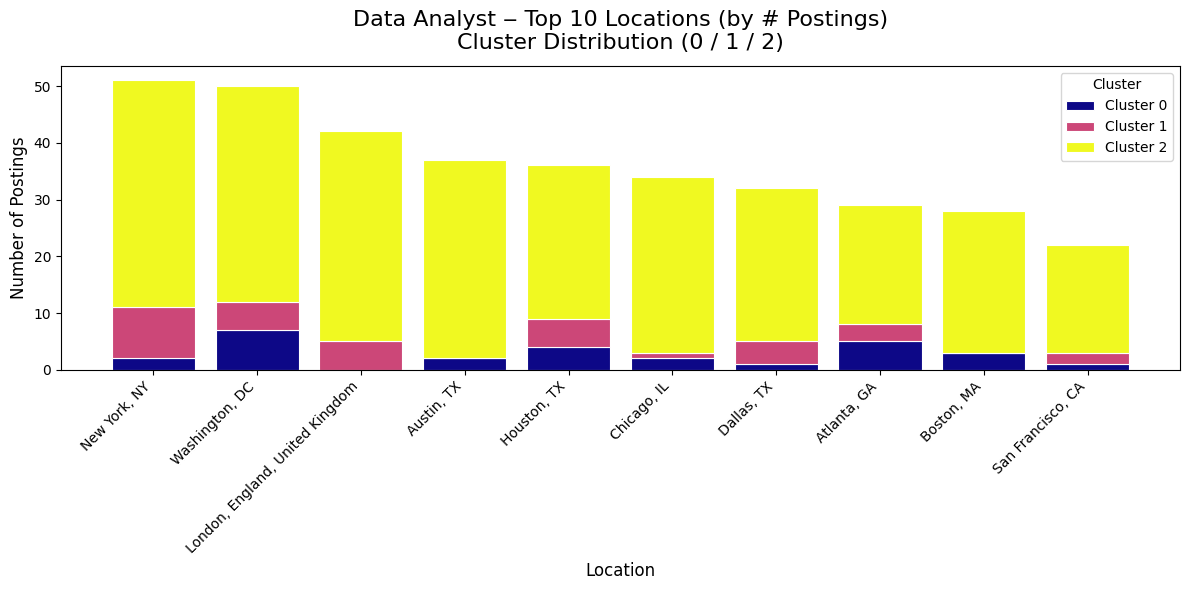

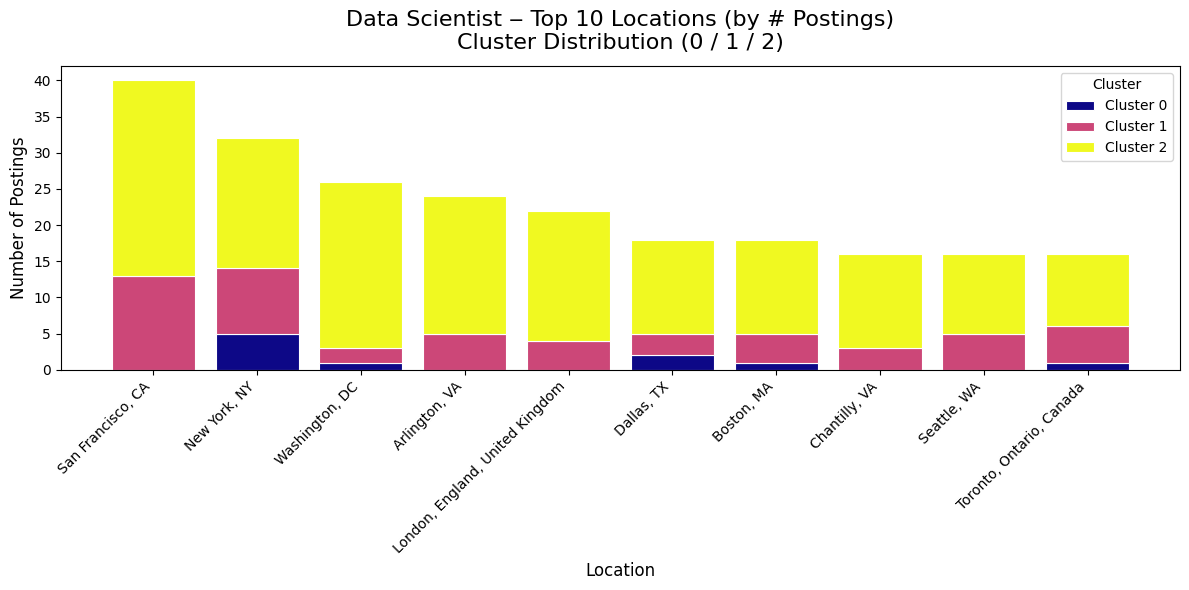

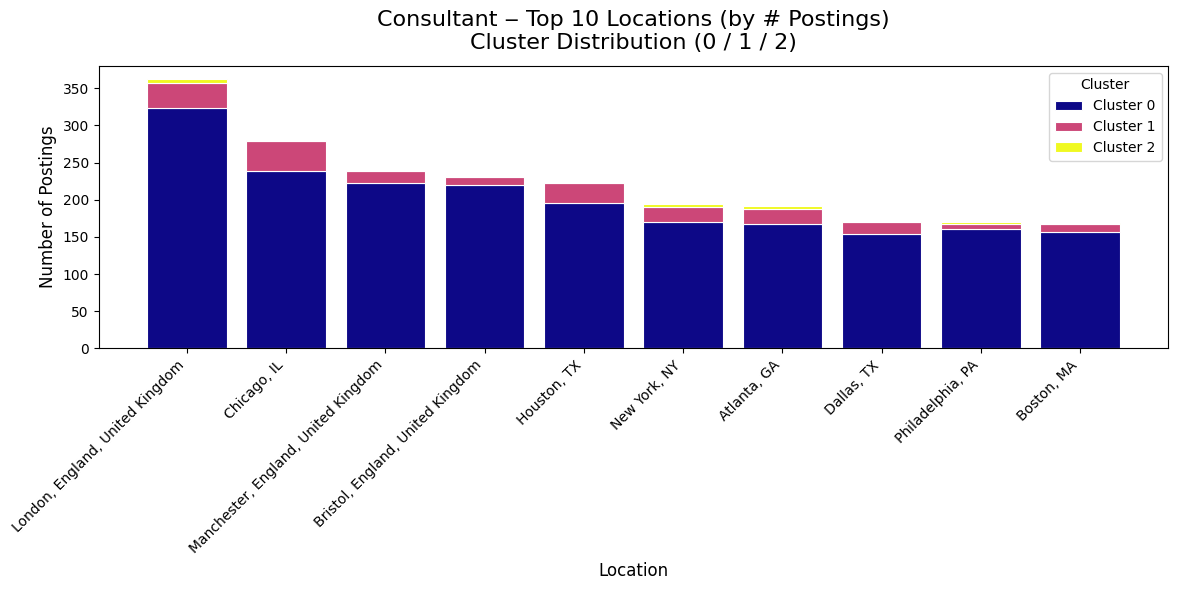

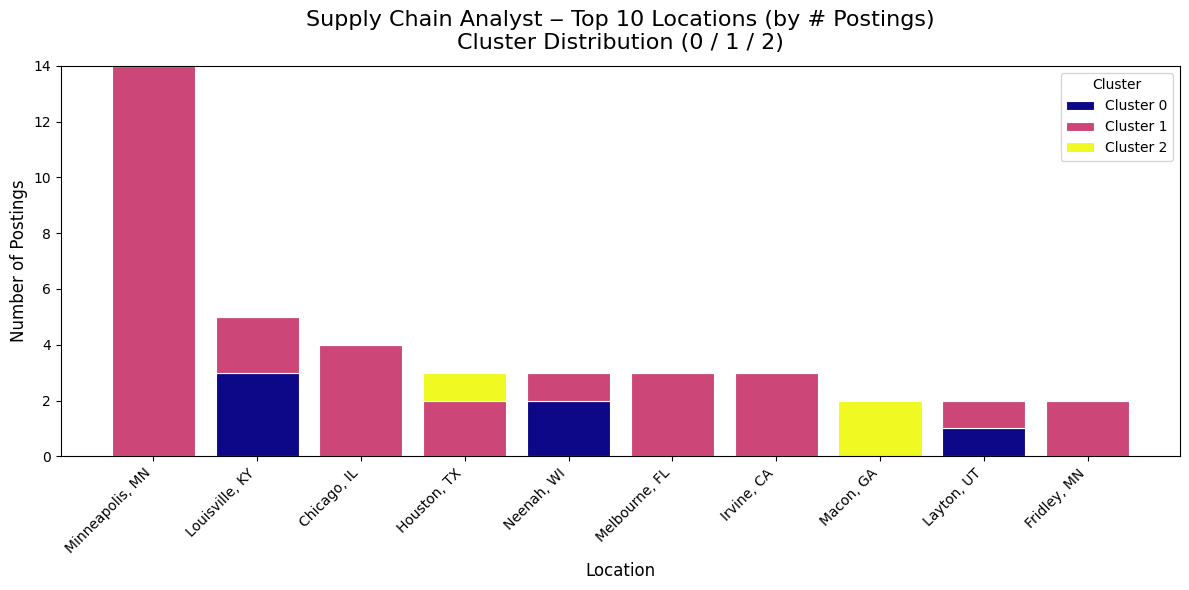

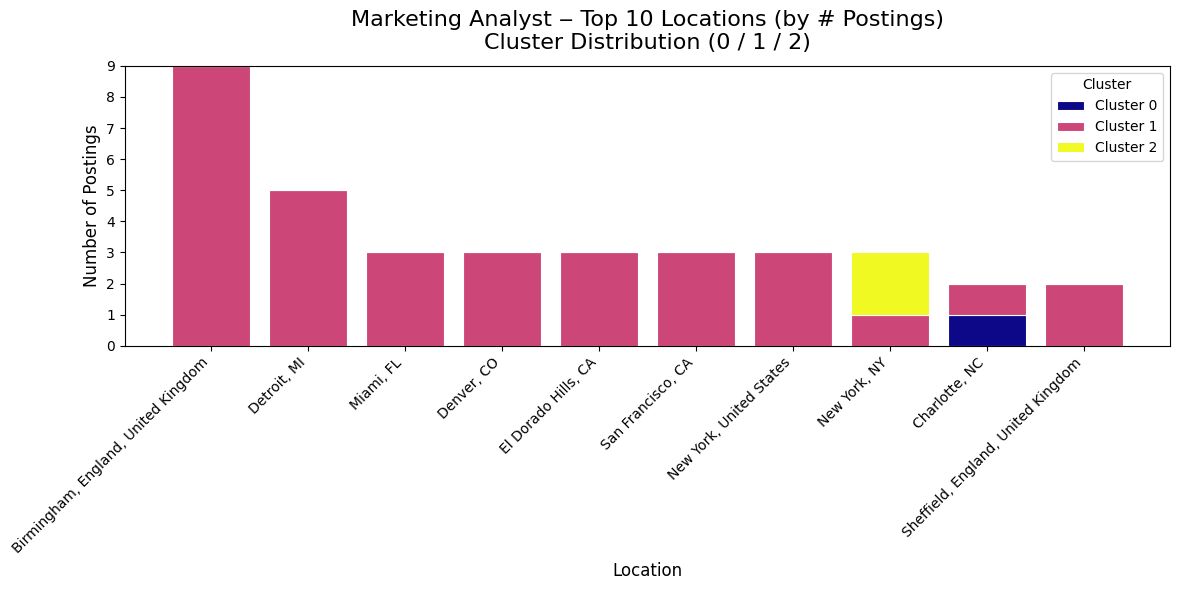

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm



N_TOP_LOCATIONS = 10


viridis_cmap = cm.get_cmap("plasma", 3)

# Sample evenly spaced colors from that colormap:
CLUSTER_COLORS = [viridis_cmap(i) for i in range(3)]

for role_name, info in results.items():
    cluster_df = info["cluster_counts_by_location"].copy()

    # 1) Sum across the three clusters to get a “total” column
    cluster_df["total"] = cluster_df.sum(axis=1)

    # 2) Pick the top N locations by total
    top_locations = cluster_df.sort_values("total", ascending=False).head(N_TOP_LOCATIONS)

    # 3) Only the cluster columns (0, 1, 2)
    plot_df = top_locations[[0, 1, 2]].astype(int)

    # 4) Sort so the biggest‐total locations appear on the left

    plot_df = plot_df.loc[top_locations.sort_values("total", ascending=False).index]

    # 5) Build a stacked‐bar chart
    plt.figure(figsize=(12, 6))
    bottom = np.zeros(len(plot_df), dtype=int)

    for cluster_label, color in zip([0, 1, 2], CLUSTER_COLORS):
        plt.bar(
            plot_df.index,
            plot_df[cluster_label],
            bottom=bottom,
            color=color,
            label=f"Cluster {cluster_label}",
            edgecolor="white",
            linewidth=0.8,
        )
        bottom += plot_df[cluster_label].values

    # 6) Tidy up axes & labels
    plt.title(
        f"{role_name} ‒ Top {N_TOP_LOCATIONS} Locations (by # Postings)\n"
        "Cluster Distribution (0 / 1 / 2)",
        fontsize=16,
        pad=12,
    )
    plt.xlabel("Location", fontsize=12)
    plt.ylabel("Number of Postings", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Cluster", loc="upper right")
    plt.tight_layout()

    # 7) Show
    plt.show()




# Output Explanation:
Each of these stacked‐bar charts shows the ten locations with the highest number of job postings for a given role, broken down by cluster (0 = navy, 1 = maroon, 2 = yellow). For Data Analyst, most of the top cities (e.g., New York NY, Washington DC, London) fall into cluster 2 (yellow), with smaller counts in clusters 0 and 1. In Data Scientist roles, cluster 2 again dominates (especially in San Francisco CA and New York NY), while a few locations (e.g., New York NY) also have postings in clusters 0 and 1. The Consultant chart is almost entirely cluster 0 (navy) in major hubs like London UK and Chicago IL, with very few cluster 1 or 2 postings. For Supply Chain Analyst, almost all top postings (e.g., Minneapolis MN, Chicago IL) are cluster 1 (maroon), with only occasional cluster 0 or 2 entries. Finally, Marketing Analyst roles are nearly all in cluster 1 (maroon) at each top location—only New York NY shows a small cluster 2 (yellow) and Charlotte NC a single cluster 0 posting.

Future Work: Next steps include integrating real-time salary data to correlate skill premiums with location and deploying the model as a Streamlit web app for live job market monitoring.

In [28]:
import plotly.express as px
import plotly.graph_objects as go

state_centroids = {
    "AL": {"lat": 32.806671, "lon": -86.791130},
    "AK": {"lat": 61.370716, "lon": -152.404419},
    "AZ": {"lat": 33.729759, "lon": -111.431221},
    "AR": {"lat": 34.969704, "lon": -92.373123},
    "CA": {"lat": 36.116203, "lon": -119.681564},
    "CO": {"lat": 39.059811, "lon": -105.311104},
    "CT": {"lat": 41.597782, "lon": -72.755371},
    "DE": {"lat": 39.318523, "lon": -75.507141},
    "FL": {"lat": 27.766279, "lon": -81.686783},
    "GA": {"lat": 33.040619, "lon": -83.643074},
    "HI": {"lat": 21.094318, "lon": -157.498337},
    "ID": {"lat": 44.240459, "lon": -114.478828},
    "IL": {"lat": 40.349457, "lon": -88.986137},
    "IN": {"lat": 39.849426, "lon": -86.258278},
    "IA": {"lat": 42.011539, "lon": -93.210526},
    "KS": {"lat": 38.526600, "lon": -96.726486},
    "KY": {"lat": 37.668140, "lon": -84.670067},
    "LA": {"lat": 31.169546, "lon": -91.867805},
    "ME": {"lat": 44.693947, "lon": -69.381927},
    "MD": {"lat": 39.063946, "lon": -76.802101},
    "MA": {"lat": 42.230171, "lon": -71.530106},
    "MI": {"lat": 43.326618, "lon": -84.536095},
    "MN": {"lat": 45.694454, "lon": -93.900192},
    "MS": {"lat": 32.741646, "lon": -89.678696},
    "MO": {"lat": 38.456085, "lon": -92.288368},
    "MT": {"lat": 46.921925, "lon": -110.454353},
    "NE": {"lat": 41.125370, "lon": -98.268082},
    "NV": {"lat": 38.313515, "lon": -117.055374},
    "NH": {"lat": 43.452492, "lon": -71.563896},
    "NJ": {"lat": 40.298904, "lon": -74.521011},
    "NM": {"lat": 34.840515, "lon": -106.248482},
    "NY": {"lat": 42.165726, "lon": -74.948051},
    "NC": {"lat": 35.630066, "lon": -79.806419},
    "ND": {"lat": 47.528912, "lon": -99.784012},
    "OH": {"lat": 40.388783, "lon": -82.764915},
    "OK": {"lat": 35.565342, "lon": -96.928917},
    "OR": {"lat": 44.572021, "lon": -122.070938},
    "PA": {"lat": 40.590752, "lon": -77.209755},
    "RI": {"lat": 41.680893, "lon": -71.511780},
    "SC": {"lat": 33.856892, "lon": -80.945007},
    "SD": {"lat": 44.299782, "lon": -99.438828},
    "TN": {"lat": 35.747845, "lon": -86.692345},
    "TX": {"lat": 31.054487, "lon": -97.563461},
    "UT": {"lat": 40.150032, "lon": -111.862434},
    "VT": {"lat": 44.045876, "lon": -72.710686},
    "VA": {"lat": 37.769337, "lon": -78.169968},
    "WA": {"lat": 47.400902, "lon": -121.490494},
    "WV": {"lat": 38.491226, "lon": -80.954456},
    "WI": {"lat": 44.268543, "lon": -89.616508},
    "WY": {"lat": 42.755966, "lon": -107.302490},
}


us_states_list = set(state_centroids.keys())
TOP_N = 5

for role_name, info in results.items():
    cluster_df = info["cluster_counts_by_location"].copy()
    cluster_df["total"] = cluster_df[[0,1,2]].sum(axis=1)
    grand_total = cluster_df["total"].sum()
    if grand_total == 0:
        print(f"⚠️ Role '{role_name}' has no U.S. postings → skipping.")
        continue
    cluster_df["percent"] = (cluster_df["total"] / grand_total) * 100.0

    df_perc = (
        cluster_df[["percent"]]
        .reset_index()
        .rename(columns={"index": "state"})
    )
    # Only keep valid states
    df_perc = df_perc[df_perc["state"].isin(us_states_list)].copy()
    if df_perc.empty:
        print(f"⚠️ Role '{role_name}' → all states fell outside U.S. → skipping.")
        continue

    # Keep only the top TOP_N by percent
    df_perc = df_perc.sort_values("percent", ascending=False).head(TOP_N)

    # Create the choropleth using only those top states:
    fig = px.choropleth(
        df_perc,
        locations="state",
        locationmode="USA-states",
        color="percent",
        scope="usa",
        hover_name="state",
        hover_data={"percent": True, "state": False},
        color_continuous_scale="Greens",
        labels={"percent": "% of Postings"},
        title=f"{role_name} — Top {TOP_N} States (by % of Postings)"
    )

    # Overlay text labels at each state’s centroid
    scatter_lats, scatter_lons, scatter_texts = [], [], []
    for _, row in df_perc.iterrows():
        st, pct = row["state"], row["percent"]
        lat = state_centroids[st]["lat"]
        lon = state_centroids[st]["lon"]
        scatter_lats.append(lat)
        scatter_lons.append(lon)
        scatter_texts.append(f"{st} – {pct:.1f}%")

    fig.add_trace(
        go.Scattergeo(
            locationmode="USA-states",
            lon=scatter_lons,
            lat=scatter_lats,
            text=scatter_texts,
            mode="text",
            hoverinfo="skip",
            textfont=dict(size=12, color="black")
        )
    )

    fig.update_layout(
        margin={"r": 0, "t": 60, "l": 0, "b": 0},
        coloraxis_colorbar={
            "title": "% of Postings",
            "ticksuffix": "%",
            "lenmode": "fraction",
            "len": 0.7,
        }
    )

    fig.show()


# Output Explanation:
**Data Analyst**: Washington (14 %), Illinois (14.5 %), California (13.5 %), Arizona (12 %) and Florida (11 %) together account for the majority of Data Analyst postings, with Illinois and Washington slightly ahead of California.

**Data Scientist**: Georgia leads with 15.5 % of postings, followed by Florida at 13.2 %, and California, Texas, and Massachusetts each around 10.5 %.

**Consultant**: Illinois and Washington both represent 14.4 % of Consultant jobs, with Texas at 13.3 %, Florida at 11.7 %, and California at 10.6 %.

**Supply Chain Analyst**: Florida dominates with 15.4 % of listings, Illinois at 13.7 %, and both Georgia and Texas at 11.6 %; New York completes the top 5 at 10 %.

**Marketing Analyst**: New York leads at 14 %, California and Florida each at 13 %, with Illinois and Georgia tied at 11.6 % of Marketing Analyst opportunities.


# Conclusion:
Our analysis of 2025 job postings shows that top roles require a blended mix of technical and soft skills: Data professionals must pair languages like Python and SQL with communication and teamwork, while Consultants and Supply Chain Analysts balance domain expertise (e.g., finance, SAP) with collaboration. Sentiment and rating data from Glassdoor reviews enable modestly accurate churn predictions (AUC ≈ 0.64), highlighting that low overall ratings and negative pros/cons language often precede departures. Finally, geographic clustering reveals that tech hubs (California, New York) favor “emerging” analytics skills (Machine Learning, Python), whereas finance and manufacturing centers (Illinois, Texas, Florida) still emphasize “legacy” domain knowledge supplemented by data tools. In short, success in 2025 hinges on forging interdisciplinary skillsets, leveraging sentiment metrics to retain talent, and tailoring hiring strategies to each region’s unique demand mix.
